###  Goal: Determine the velocity of the gas

This code uses ppxf and my own methods to fit the velocity of the gas lines in both one and two components.

In [2]:
import os
import sys
import glob

import warnings
warnings.filterwarnings('ignore') # Some things we'll be doing throw runtimewarnings that we won't care about. 

from astropy.io import fits
from astropy.wcs import WCS

import astropy.constants as const
import astropy.units as u
from astropy.visualization import astropy_mpl_style

import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm

### This is magic for Jupyer Notebooks. 
### Delete if putting into a script!
%matplotlib inline 
#######################################

import imageio 
import ppxf
print(ppxf.__version__)

7.2.0


In [3]:

galaxy = 'HE0045-2145'#'HE0045-2145'#MUSE/HE0150-0344/
cars_data_directory = 'MUSE/'+str(galaxy)+'/'

Make sure that all necessary data files are visible to this notebook: 

In [4]:
# This is the unfit data in 3D, x, y, spec
image_file = cars_data_directory + str(galaxy)+ '.unbinned.fits'
hdulist = fits.open(image_file)
hdulist.info()

# The continuum and eline model which have already been fit for each spaxel
cont_model = fits.open('/Users/beckynevin/CfA_Code/CARS_data/MUSE/HE0045-2145/fitting/full/'+galaxy+'.cont_model.fits')
eline_model = fits.open('/Users/beckynevin/CfA_Code/CARS_data/MUSE/HE0045-2145/fitting/full/'+galaxy+'.eline_model.fits')

z = 0.021 # The redshift, which I just grabbed from NED. Doesn't need to be too exact for our purposes.  
cz = z * const.c.to('km/s') # The stellar systemic velocity that we'll subtract off of our velocity maps. I always use Astropy Units - read up on them if you're not famililar!
c = const.c.to('km/s')

Filename: MUSE/HE0045-2145/HE0045-2145.unbinned.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  DATA          1 PrimaryHDU      44   (319, 314, 3682)   float32   
  1  ERROR         1 ImageHDU         9   (319, 314, 3682)   float32   


In [5]:
stars = cars_data_directory + str(galaxy)+ '.stellar_table.fits' # The Voronoi-binned Stellar Kinematics Tablegas = cars_data_directory + 'HE0227-0913.eline_table.fits' # The UNBINNED Gas kinematics Table
stars = cars_data_directory + str(galaxy)+'.kin_table.fits' 
# Read in the stellar table, from which we'll make stellar maps


stellar_hdu = fits.open(stars)

wcs = WCS(stellar_hdu[0].header, naxis=1)
print(wcs)

WCS Transformation

This transformation has 1 pixel and 1 world dimensions

Array shape (Numpy order): None

Pixel Dim  Data size  Bounds
        0       None  None

World Dim  Physical Type  Units
        0  None           unknown

Correlation between pixel and world axes:

           Pixel Dim
World Dim    0
        0  yes


[6212.4795 6212.4795 6212.4795 ... 6212.724  6212.724  6212.724 ]
The stellar systemic velocity as measured by MUSE is z=0.02136


<Figure size 432x288 with 0 Axes>

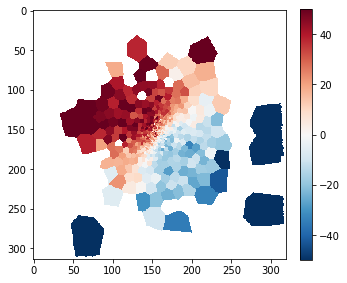

In [6]:

stellar_tab = stellar_hdu[1].data

stellar_columns = stellar_hdu[1].header
# Make arrays for the spatial coordinates
stellar_x_cor = stellar_tab.field('x_cor')
stellar_y_cor = stellar_tab.field('y_cor')

# Populate arrays for the Stellar Velocity
stellar_vel = stellar_tab.field('vel_fit')

print(stellar_vel)
stellar_vel_err = stellar_tab.field('vel_fit_err')

# ... and the FWHM! 
stellar_fwhm = stellar_tab.field('disp_fit')
stellar_fwhm_err = stellar_tab.field('disp_fit_err')

# This just creates a boolean "mask" for the data, showing only S/N > 500 spaxels. 
# We also clip low and high velocity outliers that are near the edge of the FoV. This is bad data.
stellar_select = ((stellar_vel / stellar_vel_err) > 500.0) 
#& (stellar_vel > 4400 ) & (stellar_vel < 5200)
dim = hdulist[0].data[0,:,:].shape
stellar_vel_map = np.full((dim[0], dim[1]), np.nan)

#stellar_vel_map[stellar_y_cor[stellar_select], stellar_x_cor[stellar_select]] = stellar_vel[stellar_select]

median_stellar_vel = np.median(stellar_vel[stellar_select])

measured_MUSE_redshift = (median_stellar_vel * (u.km/u.s)) / const.c.to('km/s')

print("The stellar systemic velocity as measured by MUSE is z={}".format(measured_MUSE_redshift.round(5)))

stellar_vel_map[stellar_y_cor[stellar_select], stellar_x_cor[stellar_select]] = stellar_vel[stellar_select] - median_stellar_vel 



plt.clf()
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)#, projection=wcs)#projection=wcs)
#ax.coords[0].set_axislabel('Right Ascension', fontsize=fontsize)
#ax.coords[1].set_axislabel('Declination', fontsize=fontsize)

frame = ax.imshow(stellar_vel_map,  cmap='RdBu_r', vmin=-50, vmax=50, interpolation='None')
plt.colorbar(frame, fraction=0.045)




#frame = ax.imshow(fovdata, origin='lower', norm=LogNorm(), vmin=0.001, vmax=0.5, cmap=cmap, interpolation='None')

# So then we have used the stellar velocity field to determine the best fit stellar velocity,
# which we will use as the systemic velocity

In [ ]:
0

<Figure size 432x288 with 0 Axes>

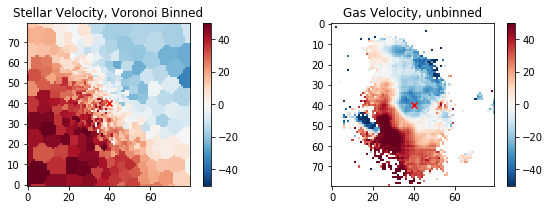

systemic velocity 6295.641618 corrected for special relativity 6166.152417238002


In [7]:
# Plot the eline velocities derived already in CARS
gas = cars_data_directory + str(galaxy)+'.eline_table.fits' # The UNBINNED Gas kinematics Table (not binned 2x2)
eline_hdu = fits.open(gas)
eline_tab = eline_hdu[1].data


Ha_vel = eline_tab.field('Halpha_vel')
Ha_flux = eline_tab.field('Halpha_flux')
Ha_flux_err = eline_tab.field('Halpha_flux_err')
gas_select = (Ha_flux / Ha_flux_err > 10)
median_Ha_vel = np.median(Ha_vel[gas_select])

#print(np.sqrt(np.shape(Ha_vel)[0]))

dim = hdulist[0].data[0,:,:].shape

eline_x_cor = eline_tab.field('x_cor')
eline_y_cor = eline_tab.field('y_cor')

Ha_vel_map = np.full((dim[0],dim[1]) ,np.nan)
Ha_vel_map[eline_y_cor[gas_select],eline_x_cor[gas_select]] = Ha_vel[gas_select] - c.value*measured_MUSE_redshift#/(1+z)

interval=40
middle_x = int(dim[0]/2)
middle_y = int(dim[1]/2)
plt.clf()
fig = plt.figure(figsize=(10,3))
ax0 = fig.add_subplot(121)
im0 = ax0.imshow(stellar_vel_map[middle_x-interval:middle_x+interval,middle_y-interval:middle_y+interval], origin='lower', cmap='RdBu_r', vmin=-50, vmax=50, interpolation='None')
plt.colorbar(im0)
ax0.set_title('Stellar Velocity, Voronoi Binned')
ax0.scatter(interval, interval, color='red', marker='x')
#ax0.set_xlim([0,39])
#ax0.set_ylim([0,39])

ax1 = fig.add_subplot(122)
im1 = ax1.imshow(np.flipud(Ha_vel_map[middle_x-interval:middle_x+interval,middle_y-interval:middle_y+interval]), 
                 cmap='RdBu_r', vmin=-50, vmax=50)
plt.colorbar(im1)
ax1.scatter(interval, interval, color='red', marker='x')
ax1.set_title('Gas Velocity, unbinned')

plt.show()

print('systemic velocity', c.value*z, 'corrected for special relativity', c.value*z/(1+z))

###  So next to check if the ppxf output for the one Gaussian fit matches
(And then to do my own one Gaussian fit and see how everything lines up)

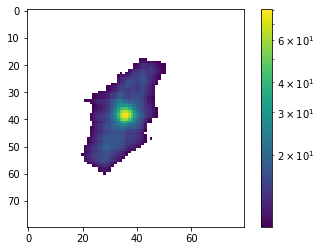

(80, 80)


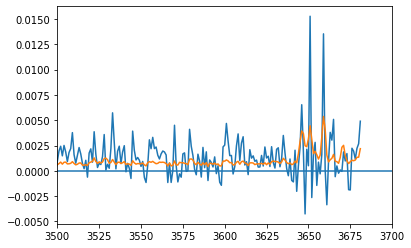

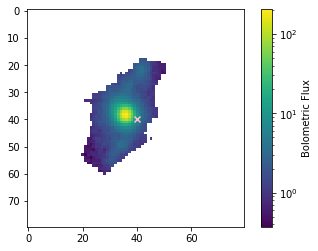

In [8]:
# Cutting at 3600 because there are some weird negative values in the spectrum
# that cause ppxf to fail that are redward of this index
import matplotlib
S_N = np.mean(hdulist[0].data[:3600,middle_x-interval:middle_x+interval,middle_y-interval:middle_y+interval]/hdulist[1].data[:3600,middle_x-interval:middle_x+interval,middle_y-interval:middle_y+interval], axis=0)

plt.imshow(np.ma.masked_where(S_N<10, S_N), norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.show()

print(np.shape(S_N))

plt.clf()
plt.plot(hdulist[0].data[:,middle_x-interval:middle_x+interval,middle_y-interval:middle_y+interval][:,2,3])

plt.plot(hdulist[1].data[:,middle_x-interval:middle_x+interval,middle_y-interval:middle_y+interval][:,2,3])
plt.xlim([3500,3700])
#plt.xlim([-10,100])
plt.axhline(y=0)
plt.show()



cut = hdulist[0].data[:3600,middle_x-interval:middle_x+interval,middle_y-interval:middle_y+interval] - cont_model[0].data[:3600,middle_x-interval:middle_x+interval,middle_y-interval:middle_y+interval]
cut_error = hdulist[1].data[:3600,middle_x-interval:middle_x+interval,middle_y-interval:middle_y+interval]
eline_model_cut = eline_model[0].data[:3600,middle_x-interval:middle_x+interval,middle_y-interval:middle_y+interval]

# Check the cut
plt.clf()
plt.imshow(np.ma.masked_where(S_N<10, np.sum(cut, axis=0)), norm = matplotlib.colors.LogNorm())
plt.colorbar(label='Bolometric Flux')
plt.scatter(40,40, color='pink', marker='x')
plt.show()


xs = np.linspace(0,np.shape(hdulist[0].data)[0]-1,np.shape(hdulist[0].data)[0])
wav = [hdulist[0].header['CRVAL3'] + hdulist[0].header['CDELT3']*x for x in xs]
wave_cut = wav[:3600]


In [12]:
from ppxf_doubleG import ppxf_indiv
from ppxf_singleG import ppxf_single

len1 = np.shape(cut)[1]
len2 = len1

vel1 = np.zeros((len1, len2))
vel2 = np.zeros((len1, len2))
sig1 = np.zeros((len1, len2))
sig2 = np.zeros((len1, len2))
chi2 = np.zeros((len1, len2))

chi = np.zeros((len1, len2))
sig = np.zeros((len1, len2))
vel = np.zeros((len1, len2))
v = np.zeros((len1, len2))





for i in range(len1):
    for j in range(len2):
        pix1 = i
        pix2 = j
        
        if S_N[pix1,pix2] < 10:
            
            continue

        '''if np.max(rebin[:,pix1,pix2]) < 1:
            continue'''
        
        
        try:
            out_ppxf_1 = ppxf_single('HE0045',measured_MUSE_redshift,lambda_spec = wave_cut, galaxy_lin=cut[:,pix1,pix2],
              error_lin=cut_error[:,pix1,pix2],
               reflines='reflines_tex.dat', 
                                 plotfile='ppxf_fit/HE0045_1gauss_'+str(pix1)+'_'+str(pix2)+'.pdf',
                                cars_model=eline_model_cut[:,pix1,pix2])
        
        
        
        except ValueError:
            
            try:
                print('multiply by 10')
                out_ppxf = ppxf_indiv('HE0045',measured_MUSE_redshift, lambda_spec = wave_cut, galaxy_lin=10*cut[:,pix1,pix2],
                  error_lin=10*cut_error[:,pix1,pix2],
                   reflines='reflines_tex.dat', plotfile='ppxf_fit/HE0045_1gauss_'+str(pix1)+'_'+str(pix2)+'.pdf',
                                cars_model=eline_model_cut[:,pix1,pix2])
            except ValueError:
                chi[i,j] = 999
                
                continue
        v[i,j] = out_ppxf_1[0]
        vel[i,j] = out_ppxf_1[1]
        sig[i,j] = out_ppxf_1[2]
        chi[i,j] = out_ppxf_1[3]
        
save_array = np.array([v, vel, sig, chi]).T
np.save('output_ppxf_1G.npy', save_array)

#return zfit_stars, sigma_stars, sigma_blr, wave, pp.bestfit


FWHM 2.94293115438
Emission lines included in gas templates:
['Hbeta' 'Halpha' '[SII]6716' '[SII]6731' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
 Best Fit:       Vel     sigma
 comp.  0:        21         0
chi2/DOF: 0.3495
method = capfit; Jac calls: 5; Func calls: 32; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  7 / 7
Templates weights:
    0.0575      1.22     0.146    0.0928     0.008    0.0305     0.491
z_obs 7.07602744145e-05
c 299792.458
vel_gas 21.2133965955
FWHM 2.94293115438
Emission lines included in gas templates:
['Hbeta' 'Halpha' '[SII]6716' '[SII]6731' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
 Best Fit:       Vel     sigma
 comp.  0:        20         0
chi2/DOF: 0.3441
method = capfit; Jac calls: 5; Func calls: 32; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  7 / 7
Templates weights:
    0.0446      1.46     0.195     0.133   0.00815    0.0173     0.567
z_obs 6.67011240161e-05
c 299792.458
vel_gas 19.9964939201
FWHM 2.94293092654
Emissio

 Best Fit:       Vel     sigma
 comp.  0:        10         1
 comp.  1:         3         4
chi2/DOF: 0.3786
method = capfit; Jac calls: 6; Func calls: 54; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  10 / 14
Templates weights:
      0.06      11.8     0.751      1.15         0         0      5.26      0.39         0     0.918    0.0641     0.121     0.281         0
(3593, 7)
FWHM 2.94293047049
Emission lines included in gas templates:
['Hbeta' 'Halpha' '[SII]6716' '[SII]6731' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
 Best Fit:       Vel     sigma
 comp.  0:        12        16
chi2/DOF: 0.3234
method = capfit; Jac calls: 7; Func calls: 52; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  7 / 7
Templates weights:
      0.24     0.303    0.0486    0.0342    0.0796    0.0107     0.132
z_obs 3.83789492e-05
c 299792.458
vel_gas 11.5057195161
FWHM 2.94293092654
Emission lines included in gas templates:
['Hbeta' 'Halpha' '[SII]6716' '[SII]6731' '[OIII]5007_d' '[O

KeyboardInterrupt: 

(80, 80, 4)


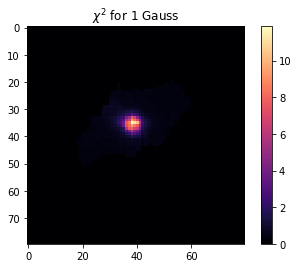

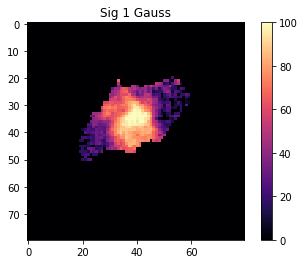

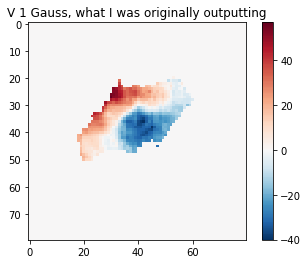

In [20]:
# Load up the 1G fit: 
save_data = np.load('output_ppxf_1G.npy')
print(np.shape(save_data))
v = save_data[:,:,0] 
vel = save_data[:,:,1] 
sig = save_data[:,:,2] 
chi = save_data[:,:,3] 

import matplotlib
import numpy.ma as ma
c=3e5

class MidpointNormalize(matplotlib.colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


plt.clf()
plt.imshow(chi, cmap='magma')
plt.colorbar()
plt.title('$\chi^2$ for 1 Gauss')
plt.show()


plt.clf()
plt.imshow(sig, cmap='magma', vmax=100)
plt.title('Sig 1 Gauss')
plt.colorbar()
plt.show()

plt.clf()
plt.imshow(v, cmap='RdBu_r', norm=MidpointNormalize(midpoint=0))
plt.title('V 1 Gauss, what I was originally outputting')
plt.colorbar()
plt.show()



<Figure size 432x288 with 0 Axes>

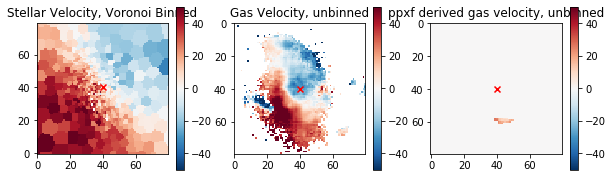

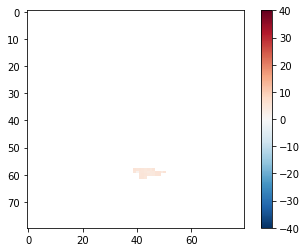

In [13]:
plt.clf()
fig = plt.figure(figsize=(10,3))
ax0 = fig.add_subplot(131)
im0 = ax0.imshow(stellar_vel_map[middle_x-interval:middle_x+interval,middle_y-interval:middle_y+interval], origin='lower', cmap='RdBu_r', vmin=-50, vmax=50, interpolation='None')
plt.colorbar(im0)
ax0.set_title('Stellar Velocity, Voronoi Binned')
ax0.scatter(interval, interval, color='red', marker='x')
#ax0.set_xlim([0,39])
#ax0.set_ylim([0,39])

ax1 = fig.add_subplot(132)
im1 = ax1.imshow(np.flipud(Ha_vel_map[middle_x-interval:middle_x+interval,middle_y-interval:middle_y+interval]), 
                 cmap='RdBu_r', vmin=-50, vmax=50)
plt.colorbar(im1)
ax1.scatter(interval, interval, color='red', marker='x')
ax1.set_title('Gas Velocity, unbinned')

ax2 = fig.add_subplot(133)
im2 = ax2.imshow(np.flipud(v),cmap='RdBu_r', vmin=-50, vmax=50)
plt.colorbar(im2)
ax2.scatter(interval, interval, color='red', marker='x')

ax2.set_title('ppxf derived gas velocity, unbinned')

plt.show()

plt.clf
plt.imshow(np.ma.masked_where(np.flipud(v)==0,np.flipud(Ha_vel_map[middle_x-interval:middle_x+interval,middle_y-interval:middle_y+interval])) - np.flipud(v), 
          vmin=-40, vmax=40, cmap='RdBu_r')
plt.colorbar()
plt.show()


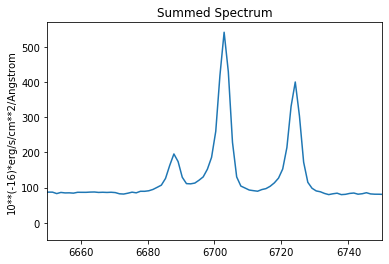

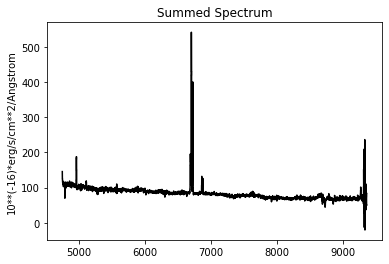

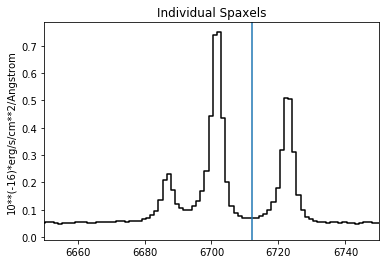

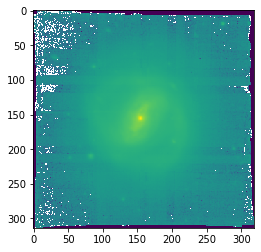

<Quantity 6571.661422600985>

In [14]:
###  Now I'm going to attempt to fit this stingray myself (just Halpha)
import matplotlib
plt.clf()

plt.plot(wav, np.sum(hdulist[0].data, axis=(1,2)))
plt.title('Summed Spectrum')
plt.ylabel(str(hdulist[0].header['BUNIT']))
plt.xlim([6650, 6750])
plt.show()

plt.clf()
#xs, ys = np.histogram(np.sum(hdulist[0].data, axis=(1,2)), bins = wav)
plt.step(wav, np.sum(hdulist[0].data, axis=(1,2)), color='black')
#plt.scatter(ys[:-1],xs, color='black')
plt.title('Summed Spectrum')
plt.ylabel(str(hdulist[0].header['BUNIT']))
#plt.xlim([6650, 6750])
plt.show()

plt.clf()

plt.step(wav, hdulist[0].data[:,middle_x, middle_y], color='black')
#plt.plot(wav, hdulist[0].data[:,140,150])
plt.title('Individual Spaxels')
plt.ylabel(str(hdulist[0].header['BUNIT']))
plt.xlim([6650, 6750])
plt.axvline(x=6712)
plt.show()

plt.imshow(np.sum(hdulist[0].data, axis=0), norm=matplotlib.colors.LogNorm())
plt.show()

6712/(1+measured_MUSE_redshift)

In [10]:
# Fit a Gauss to this:
import scipy

def one_gauss_fit(x, a, mu, sigma):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))
def two_gauss_fit(x, a, mu, sigma, a2, mu2, sigma2):
    return a*np.exp(-(x-mu)**2/(2*sigma**2)) + a2*np.exp(-(x-mu2)**2/(2*sigma2**2)) 
def linefit(x,m,b):
 
    return [m*i + b for i in x]


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]




def fit_gaussians_aik(wav, data, error, pix_x, pix_y , guess_mu):

    popt = 0
    

    # first, fit a line:
    poptline, pcov = scipy.optimize.curve_fit(linefit, wav, data, p0=[0.1,np.min(data)])
    line = linefit(wav, *poptline)
    #line = [line_y for x in wav[idx_1:idx_2]]
    
    guess = [np.max(data), guess_mu, 5]
    try:
        popt, pcov = scipy.optimize.curve_fit(one_gauss_fit, wav,data, p0=guess)
    
    except:
        return 0, 0, 0
    gauss_1 = one_gauss_fit(wav, *popt)

    # Now fit 2 Gauss
    guess2 = [popt[0]/2, popt[1], popt[2], popt[0]/2, popt[1]-2, popt[2]]
    try:
        popt2, pcov2 = scipy.optimize.curve_fit(two_gauss_fit, wav,data, p0=guess2)
    except:
        plt.clf()
        plt.step(wav, data)
        plt.show()
        return 0, 0, 0
    
    gauss_2_1 = one_gauss_fit(wav, *[popt2[0], popt2[1], popt2[2]])
    gauss_2_2 = one_gauss_fit(wav, *[popt2[3], popt2[4], popt2[5]])
    gauss_2 = two_gauss_fit(wav, *popt2)

    chi_line = np.sum(abs(line - data)**2/error**2)
    chi_1 = np.sum(abs(gauss_1 - data)**2/error**2)
    chi_2 = np.sum(abs(gauss_2 - data)**2/error**2)

    n = idx_2 - idx_1

    k = 2
    aik_line = chi_line + 2*k + 2*k*(k+1)/(n - k - 1)
    
    k = 3
    aik_1 = chi_1 + 2*k + 2*k*(k+1)/(n - k - 1)

    k = 6
    aik_2 = chi_2 + 2*k + 2*k*(k+1)/(n - k - 1)
    #AIC = chi +2k
    #AIC + 2k(k + 1)/(n − k − 1)

    plt.clf()
    plt.plot(wav, line, color='blue')
    plt.step(wav, data, color='black', where='mid', label='Data')
    plt.scatter(wav, data, color='black', s=5)
    plt.step(wav, one_gauss_fit(wav, *popt), color='red', label='1 Gauss', where='mid')
    #plt.step(wav[idx_1:idx_2], two_gauss_fit(wav[idx_1:idx_2], *popt2), color='orange', label='2 Gauss')#, where='mid')
    plt.step(wav, gauss_2_1, color='orange', where='mid', label='2 Gauss')
    plt.step(wav, gauss_2_2, color='orange', where='mid')

    plt.axvline(x=halpha_rest*(1+measured_MUSE_redshift), color='gray')

    plt.title('Individual Spaxels')
    plt.ylabel(str(hdulist[0].header['BUNIT']))
    plt.legend(loc='upper center', bbox_to_anchor=(1.15, 0.8))
    plt.annotate('$AIK_1$ = '+str(round(aik_1,1)), xy=(0.05, 0.95), xycoords='axes fraction', color='red')
    plt.annotate('$AIK_2$ = '+str(round(aik_2,1)), xy=(0.05, 0.9), xycoords='axes fraction', color='orange')
    
    if aik_line < aik_1 and aik_line < aik_2:
        plt.annotate('Line is best', xy=(0.05, 0.85), xycoords='axes fraction', color='black')
        fit = 0
        fit_param = poptline
    else:
        if aik_2 < aik_1 and popt2[0] > 0 and popt2[3] > 0:
            plt.annotate('Two is best', xy=(0.05, 0.85), xycoords='axes fraction', color='black')
            fit = 2
            fit_param = popt2
            
        else:
            plt.annotate('One is best', xy=(0.05, 0.85), xycoords='axes fraction', color='black')
            fit = 1
            fit_param = popt
           

    #plt.xlim([6650, 6750])
    plt.show()

    
    #data, error, gauss_1, gauss_2, gauss_2_1, gauss_2_2, aik_line, aik_1, aik_2,
    return fit, fit_param, popt



18 41


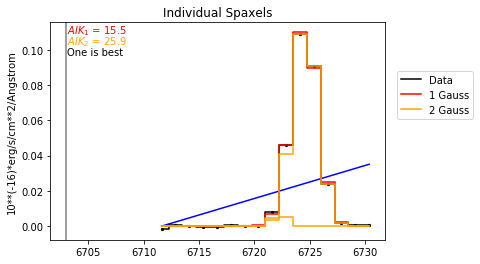

TypeError: only dimensionless scalar quantities can be converted to Python scalars

In [18]:
start_x = 6712
end_x = 6732
mu = 6723

idx_1 = find_nearest(wav, start_x)[0]
idx_2 = find_nearest(wav, end_x)[0]

wavecut = wav[idx_1:idx_2]

fit_n_NII = np.zeros((len1, len2))
vel_narrow_NII = np.zeros((len1, len2))
vel_broad_NII = np.zeros((len1, len2))
sig_narrow_NII = np.zeros((len1, len2))
sig_broad_NII = np.zeros((len1, len2))
vel_one_NII = np.zeros((len1, len2))
sig_one_NII = np.zeros((len1, len2))




for j in range(len1):
    for i in range(len2):
        
        data = cut[:,j,i][idx_1:idx_2]
        error = cut_error[:,j,i][idx_1:idx_2]
        
        
        if S_N[j,i] < 10:#was 10
            continue
        print(j,i) 
        '''plt.clf()
        plt.step(wav[idx_1:idx_2],data, label='Data')
        plt.step(wav[idx_1:idx_2],error, label='Noise')
        plt.legend()
        plt.title('j = '+str(j)+', i = '+str(i))
        plt.show()'''
        
        
        out = fit_gaussians_aik(wavecut, data, error, j,i, mu)
        fit_n[j,i] = out[0]
        
        
       
        if out[0] ==2:
            vel_narrow_NII[j,i] = c*(out[1][1]-6583.45*(1+measured_MUSE_redshift))/(6583.45*(1+measured_MUSE_redshift))
            sig_narrow_NII[j,i] = (out[1][2]/out[1][1])*c
            vel_broad_NII[j,i] = c*(out[1][4]-6583.45*(1+measured_MUSE_redshift))/(6583.45*(1+measured_MUSE_redshift))
            sig_broad_NII[j,i] = (out[1][5]/out[1][4])*c
        if out[0] ==1:
            vel_narrow_NII[j,i] = c*(out[1][1]-6583.45*(1+measured_MUSE_redshift))/(6583.45*(1+measured_MUSE_redshift))
            sig_narrow_NII[j,i] = (out[1][2]/out[1][1])*c
        if out[0] != 0:
            # then you can assign the one gaussian values
            vel_one_NII[j,i] = c*(out[2][1]-6583.45*(1+measured_MUSE_redshift))/(6583.45*(1+measured_MUSE_redshift))
            sig_one_NII[j,i] = (out[2][2]/out[2][1])*c
        #if out


redshifted wavelength of NII 6724.040323810667


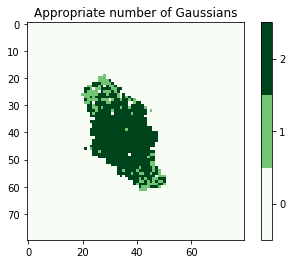

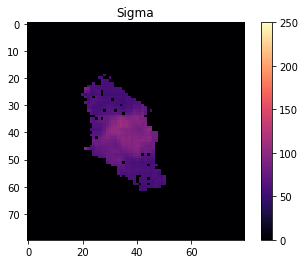

<Figure size 432x288 with 0 Axes>

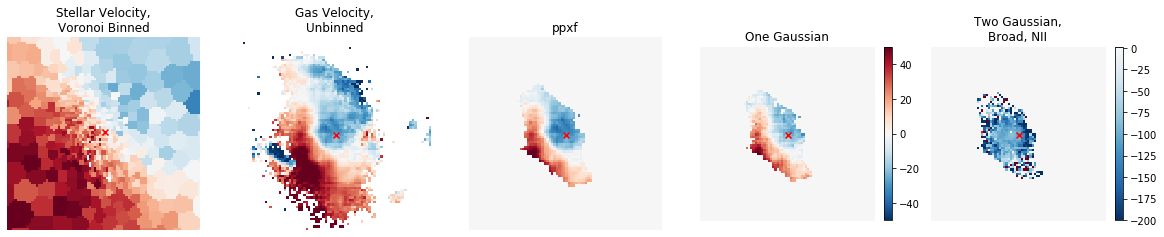

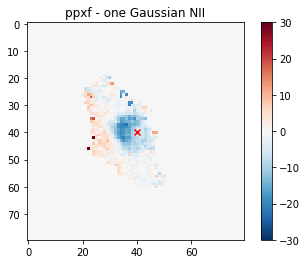

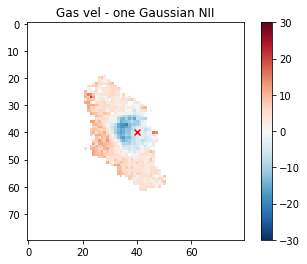

In [186]:
print('redshifted wavelength of NII', (6583.45*(1+measured_MUSE_redshift)))

plt.clf()
plt.imshow(np.flipud(fit_n), cmap=plt.cm.get_cmap('Greens', 3))

#formatter = plt.FuncFormatter(lambda val, loc: np.rot90(fit_n))

plt.colorbar(ticks=[0,1,2])#, format=formatter)
plt.clim(-0.5,2.5)
plt.title('Appropriate number of Gaussians')
plt.show()


plt.clf()
plt.imshow(abs(np.flipud(sig_one)), cmap='magma', vmax=250)
plt.colorbar()#, format=formatter)
plt.title('Sigma')
plt.show()
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

plt.clf()
fig = plt.figure(figsize=(20,5))
ax0 = fig.add_subplot(151)
im0 = ax0.imshow(stellar_vel_map[middle_x-interval:middle_x+interval,middle_y-interval:middle_y+interval], origin='lower', cmap='RdBu_r', vmin=-50, vmax=50, interpolation='None')
#plt.colorbar(im0, fraction=0.045)
ax0.set_title('Stellar Velocity,\nVoronoi Binned')
ax0.scatter(interval, interval, color='red', marker='x')
ax0.axis('off')
#ax0.set_xlim([0,39])
#ax0.set_ylim([0,39])

ax1 = fig.add_subplot(152)
im1 = ax1.imshow(np.flipud(Ha_vel_map[middle_x-interval:middle_x+interval,middle_y-interval:middle_y+interval]), 
                 cmap='RdBu_r', vmin=-50, vmax=50)
#plt.colorbar(im1, fraction=0.045)
ax1.scatter(interval, interval, color='red', marker='x')
ax1.axis('off')
ax1.set_title('Gas Velocity,\nUnbinned')

ax2 = fig.add_subplot(153)
im2 = ax2.imshow(np.rot90(v),cmap='RdBu_r', vmin=-50, vmax=50)
#plt.colorbar(im2, fraction=0.045)
ax2.scatter(interval, interval, color='red', marker='x')
ax2.axis('off')
ax2.set_title('ppxf')

ax3 = fig.add_subplot(154)
im3 = ax3.imshow(np.flipud(vel_one_NII),cmap='RdBu_r', vmin=-50, vmax=50)
plt.colorbar(im3, fraction=0.045)
ax3.scatter(interval, interval, color='red', marker='x')
ax3.axis('off')
ax3.set_title('One Gaussian')

ax4 = fig.add_subplot(155)
im4 = ax4.imshow(np.flipud(vel_broad_NII),cmap='RdBu_r',  norm=MidpointNormalize(midpoint=0, vmin=-200, vmax=1))
plt.colorbar(im4, fraction=0.045)
ax4.scatter(interval, interval, color='red', marker='x')
ax4.axis('off')
ax4.set_title('Two Gaussian,\nBroad, NII')

plt.show()

plt.clf()
im = plt.imshow(np.rot90(v) - np.flipud(vel_one_NII), cmap='RdBu_r', vmin=-30, vmax=30)
plt.scatter(interval, interval, color='red', marker='x')
plt.title('ppxf - one Gaussian NII')
plt.colorbar(im)
plt.show()

diff_2 = np.flipud(Ha_vel_map[middle_x-interval:middle_x+interval,middle_y-interval:middle_y+interval]) - np.flipud(vel_one_NII)
plt.clf()
im = plt.imshow(np.ma.masked_where(np.flipud(vel_one_NII)==0, diff_2), cmap='RdBu_r', vmin=-30, vmax=30)
plt.scatter(interval, interval, color='red', marker='x')
plt.title('Gas vel - one Gaussian NII')
plt.colorbar(im)
plt.show()

###  Now I'm going to do the same thing but for Halpha


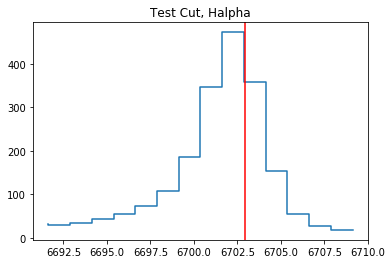

18 41


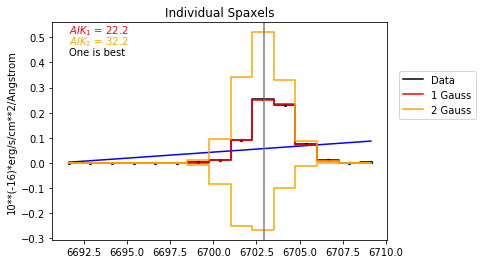

TypeError: only dimensionless scalar quantities can be converted to Python scalars

In [16]:

start_x = 6692
end_x = 6710
mu = 6701

idx_1 = find_nearest(wav, start_x)[0]
idx_2 = find_nearest(wav, end_x)[0]

wavecut = wav[idx_1:idx_2]

'''6562.801
6564.614'''

# So I'm using air
halpha_rest = 6562.801
plt.clf()
plt.title('Test Cut, Halpha')
plt.step(wavecut, np.sum(cut[idx_1:idx_2, :, :], axis=(1,2)))
plt.axvline(x=halpha_rest*(1+measured_MUSE_redshift), color='red')
plt.show()




fit_n = np.zeros((len1, len2))
vel_narrow = np.zeros((len1, len2))
vel_broad = np.zeros((len1, len2))
sig_narrow = np.zeros((len1, len2))
sig_broad = np.zeros((len1, len2))
vel_one = np.zeros((len1, len2))
sig_one = np.zeros((len1, len2))




for j in range(len1):
    for i in range(len2):
        
        data = cut[:,j,i][idx_1:idx_2]
        error = cut_error[:,j,i][idx_1:idx_2]
        
        
        if S_N[j,i] < 10:#was 10
            continue
        print(j,i) 
        '''plt.clf()
        plt.step(wav[idx_1:idx_2],data, label='Data')
        plt.step(wav[idx_1:idx_2],error, label='Noise')
        plt.legend()
        plt.title('j = '+str(j)+', i = '+str(i))
        plt.show()'''
        
        
        out = fit_gaussians_aik(wavecut, data, error, j,i, mu)
        fit_n[j,i] = out[0]
        
        
       
        if out[0] ==2:
            vel_narrow[j,i] = c*(out[1][1]-halpha_rest*(1+measured_MUSE_redshift))/(halpha_rest*(1+measured_MUSE_redshift))
            sig_narrow[j,i] = (out[1][2]/out[1][1])*c
            vel_broad[j,i] = c*(out[1][4]-halpha_rest*(1+measured_MUSE_redshift))/(halpha_rest*(1+measured_MUSE_redshift))
            sig_broad[j,i] = (out[1][5]/out[1][4])*c
        if out[0] ==1:
            vel_narrow[j,i] = c*(out[1][1]-halpha_rest*(1+measured_MUSE_redshift))/(halpha_rest*(1+measured_MUSE_redshift))
            sig_narrow[j,i] = (out[1][2]/out[1][1])*c
        if out[0] != 0:
            # then you can assign the one gaussian values
            vel_one[j,i] = c*(out[2][1]-6562.801*(1+measured_MUSE_redshift))/(6562.801*(1+measured_MUSE_redshift))
            sig_one[j,i] = (out[2][2]/out[2][1])*c
        #if out


In [1]:

plt.clf()
plt.imshow(np.flipud(fit_n), cmap=plt.cm.get_cmap('Greens', 3))

#formatter = plt.FuncFormatter(lambda val, loc: np.rot90(fit_n))

plt.colorbar(ticks=[0,1,2])#, format=formatter)
plt.clim(-0.5,2.5)
plt.title('Appropriate number of Gaussians')
plt.show()


plt.clf()
plt.imshow(abs(np.flipud(sig_one)), cmap='magma', vmax=250)
plt.colorbar()#, format=formatter)
plt.title('Sigma')
plt.show()
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

plt.clf()
fig = plt.figure(figsize=(20,5))
ax0 = fig.add_subplot(151)
im0 = ax0.imshow(stellar_vel_map[middle_x-interval:middle_x+interval,middle_y-interval:middle_y+interval], origin='lower', cmap='RdBu_r', vmin=-50, vmax=50, interpolation='None')
#plt.colorbar(im0, fraction=0.045)
ax0.set_title('Stellar Velocity,\nVoronoi Binned')
ax0.scatter(interval, interval, color='red', marker='x')
ax0.axis('off')
#ax0.set_xlim([0,39])
#ax0.set_ylim([0,39])

ax1 = fig.add_subplot(152)
im1 = ax1.imshow(np.flipud(Ha_vel_map[middle_x-interval:middle_x+interval,middle_y-interval:middle_y+interval]), 
                 cmap='RdBu_r', vmin=-50, vmax=50)
#plt.colorbar(im1, fraction=0.045)
ax1.scatter(interval, interval, color='red', marker='x')
ax1.axis('off')
ax1.set_title('Gas Velocity,\nUnbinned')

ax2 = fig.add_subplot(153)
im2 = ax2.imshow(np.rot90(v),cmap='RdBu_r', vmin=-50, vmax=50)
#plt.colorbar(im2, fraction=0.045)
ax2.scatter(interval, interval, color='red', marker='x')
ax2.axis('off')
ax2.set_title('ppxf')

ax3 = fig.add_subplot(154)
im3 = ax3.imshow(np.flipud(vel_one),cmap='RdBu_r', vmin=-50, vmax=50)
plt.colorbar(im3, fraction=0.045)
ax3.scatter(interval, interval, color='red', marker='x')
ax3.axis('off')
ax3.set_title('One Gaussian Halpha')

ax4 = fig.add_subplot(155)
im4 = ax4.imshow(np.flipud(vel_broad),cmap='RdBu_r',  norm=MidpointNormalize(midpoint=0, vmin=-200, vmax=1))
plt.colorbar(im4, fraction=0.045)
ax4.scatter(interval, interval, color='red', marker='x')
ax4.axis('off')
ax4.set_title('Two Gaussian,\nBroad')

plt.show()

# Now show all of the different gaussian fits
plt.clf()
fig = plt.figure(figsize=(10,5))
ax3 = fig.add_subplot(231)
im3 = ax3.imshow(np.flipud(vel_one),cmap='RdBu_r', vmin=-50, vmax=50)
plt.colorbar(im3, fraction=0.045)
ax3.scatter(interval, interval, color='red', marker='x')
#ax3.axis('off')
ax3.set_title('One Gaussian')
ax3.set_ylabel(r'H$\alpha$ Velocity')

ax5 = fig.add_subplot(232)
im5 = ax5.imshow(np.flipud(vel_narrow),cmap='RdBu_r', vmin=-50, vmax=50)
plt.colorbar(im5, fraction=0.045)
ax5.scatter(interval, interval, color='red', marker='x')
ax5.axis('off')
ax5.set_title('Two Gaussian,\nNarrow Component')

ax4 = fig.add_subplot(233)
im4 = ax4.imshow(np.flipud(vel_broad),cmap='RdBu_r',  norm=MidpointNormalize(midpoint=0, vmin=-200, vmax=1))
plt.colorbar(im4, fraction=0.045)
ax4.scatter(interval, interval, color='red', marker='x')
ax4.axis('off')
ax4.set_title('Two Gaussian,\nBroad Component')

ax6 = fig.add_subplot(234)
im6 = ax6.imshow(np.flipud(sig_one),cmap='magma',vmin=0, vmax=125)
plt.colorbar(im6, fraction=0.045)
ax6.scatter(interval, interval, color='red', marker='x')
#ax6.axis('off')
ax6.set_ylabel(r'H$\alpha$ Velocity Dispersion')


ax7 = fig.add_subplot(235)
im7 = ax7.imshow(np.flipud(sig_narrow),cmap='magma', vmin=0, vmax=125)
plt.colorbar(im7, fraction=0.045)
ax7.scatter(interval, interval, color='red', marker='x')
ax7.axis('off')

ax8 = fig.add_subplot(236)
im8 = ax8.imshow(np.flipud(sig_broad),cmap='magma',  vmin=100, vmax=250)
plt.colorbar(im8, fraction=0.045)
ax8.scatter(interval, interval, color='red', marker='x')
ax8.axis('off')


plt.savefig('figs/Halpha_vel_disp.pdf')

plt.clf()
im = plt.imshow(np.rot90(v) - np.flipud(vel_one), cmap='RdBu_r', vmin=-20, vmax=20)
plt.scatter(interval, interval, color='red', marker='x')
plt.title('ppxf - one Gaussian')
plt.colorbar(im)
plt.show()

diff_2 = np.flipud(Ha_vel_map[middle_x-interval:middle_x+interval,middle_y-interval:middle_y+interval]) - np.flipud(vel_one)

plt.clf()
im = plt.imshow(np.ma.masked_where(np.flipud(vel_one)==0, diff_2), cmap='RdBu_r', vmin=-10, vmax=10)
plt.scatter(interval, interval, color='red', marker='x')
plt.title('Gas velocity - one Gaussian')
plt.colorbar(im)
plt.show()

NameError: name 'plt' is not defined

###  Everything that follows is the two-Gaussian fit with ppxf (which isn't working for me)

67.3148
nan
0 0


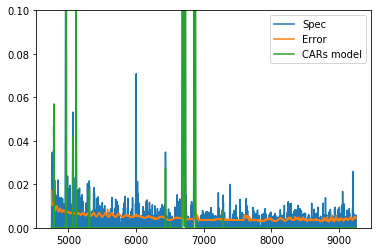

Emission lines included in gas templates:
['Hbeta' 'Halpha' '[SII]6716' '[SII]6731' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
nNLines 7 bl 7
 Best Fit:       Vel     sigma
 comp.  0:        -0        59
 comp.  1:        -0        59
chi2/DOF: 10.36
method = capfit; Jac calls: 2; Func calls: 28; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  7 / 14
Templates weights:
      2.43      28.2      2.44      2.87     0.281     0.183      20.4         0         0         0         0         0         0         0
(3592, 7)
0 1


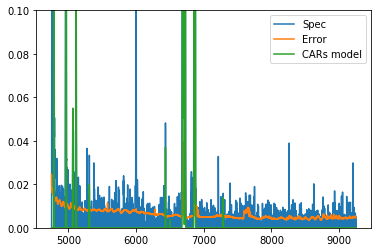

Emission lines included in gas templates:
['Hbeta' 'Halpha' '[SII]6716' '[SII]6731' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
nNLines 7 bl 7
 Best Fit:       Vel     sigma
 comp.  0:         0        50
 comp.  1:         0        50
chi2/DOF: 17.43
method = capfit; Jac calls: 1; Func calls: 20; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  7 / 14
Templates weights:
       4.4      17.2      1.09         0     0.505      0.16      13.2         0         0         0      1.34         0         0         0
(3592, 7)
0 2


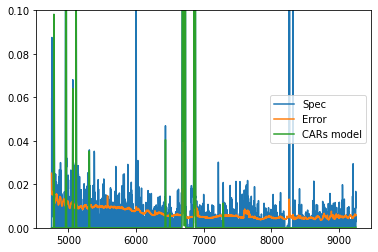

Emission lines included in gas templates:
['Hbeta' 'Halpha' '[SII]6716' '[SII]6731' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
nNLines 7 bl 7
 Best Fit:       Vel     sigma
 comp.  0:       -45        95
 comp.  1:     -2000        95
chi2/DOF: 7.228
method = capfit; Jac calls: 9; Func calls: 74; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  9 / 14
Templates weights:
      2.56      48.1      5.07      6.49     0.334     0.258      36.8         0         0     0.137         0         0         0     0.423
(3593, 7)
0 3


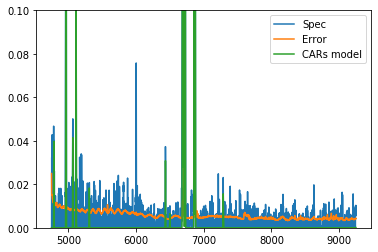

Emission lines included in gas templates:
['Hbeta' 'Halpha' '[SII]6716' '[SII]6731' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
nNLines 7 bl 7
 Best Fit:       Vel     sigma
 comp.  0:         0        50
 comp.  1:         0        50
chi2/DOF: 14.37
method = capfit; Jac calls: 1; Func calls: 20; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  7 / 14
Templates weights:
      2.77      12.1     0.782         0      0.35     0.123      9.56         0         0         0     0.917         0         0         0
(3593, 7)
1 0


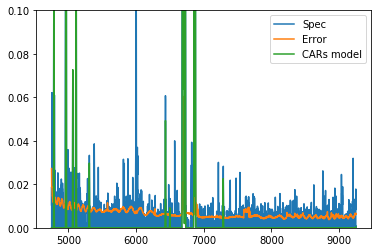

Emission lines included in gas templates:
['Hbeta' 'Halpha' '[SII]6716' '[SII]6731' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
nNLines 7 bl 7
 Best Fit:       Vel     sigma
 comp.  0:         0        50
 comp.  1:         0        50
chi2/DOF: 14.14
method = capfit; Jac calls: 1; Func calls: 20; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  7 / 14
Templates weights:
      5.41      23.6      1.33         0     0.651     0.201      17.8         0         0         0      1.73         0         0         0
(3595, 7)
1 1


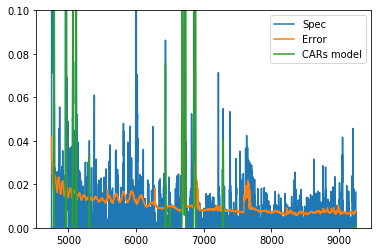

Emission lines included in gas templates:
['Hbeta' 'Halpha' '[SII]6716' '[SII]6731' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
nNLines 7 bl 7
 Best Fit:       Vel     sigma
 comp.  0:       -40       104
 comp.  1:     -2000       104
chi2/DOF: 8.64
method = capfit; Jac calls: 17; Func calls: 143; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  8 / 14
Templates weights:
      5.15       108      10.3      14.3     0.676     0.519      82.8         0         0    0.0764         0         0         0     0.653
(3593, 7)
1 2


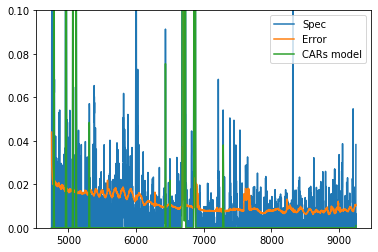

Emission lines included in gas templates:
['Hbeta' 'Halpha' '[SII]6716' '[SII]6731' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
nNLines 7 bl 7
 Best Fit:       Vel     sigma
 comp.  0:         0        50
 comp.  1:         0        50
chi2/DOF: 21.48
method = capfit; Jac calls: 1; Func calls: 20; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  7 / 14
Templates weights:
         0      39.5      1.98      2.81      1.19     0.324      32.7      9.19         0         0         0         0         0         0
(3593, 7)
1 3


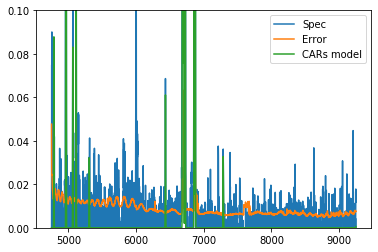

Emission lines included in gas templates:
['Hbeta' 'Halpha' '[SII]6716' '[SII]6731' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
nNLines 7 bl 7
 Best Fit:       Vel     sigma
 comp.  0:         0        50
 comp.  1:         0        50
chi2/DOF: 19.9
method = capfit; Jac calls: 1; Func calls: 20; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  7 / 14
Templates weights:
      5.67      27.2      1.36      1.81     0.745     0.224      22.2         0         0         0         0         0         0         0
(3593, 7)
2 0


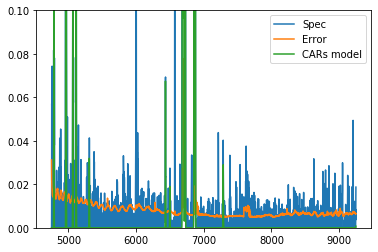

Emission lines included in gas templates:
['Hbeta' 'Halpha' '[SII]6716' '[SII]6731' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
nNLines 7 bl 7
 Best Fit:       Vel     sigma
 comp.  0:         0        50
 comp.  1:         0        50
chi2/DOF: 20.42
method = capfit; Jac calls: 1; Func calls: 20; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  7 / 14
Templates weights:
      7.17      32.5      1.68         0     0.949      0.27      25.1         0         0         0      2.38         0         0         0
(3593, 7)
2 1


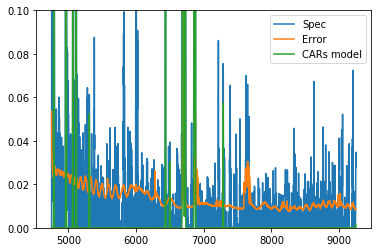

Emission lines included in gas templates:
['Hbeta' 'Halpha' '[SII]6716' '[SII]6731' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
nNLines 7 bl 7
 Best Fit:       Vel     sigma
 comp.  0:         0        50
 comp.  1:         0        50
chi2/DOF: 28.09
method = capfit; Jac calls: 1; Func calls: 20; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  7 / 14
Templates weights:
      12.7        58      2.82         0      1.67     0.479      47.3         0         0         0      4.21         0         0         0
(3593, 7)
2 2


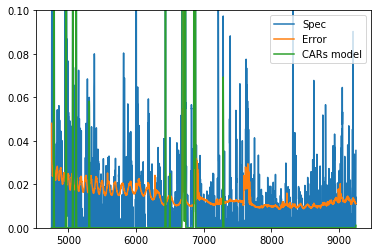

Emission lines included in gas templates:
['Hbeta' 'Halpha' '[SII]6716' '[SII]6731' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
nNLines 7 bl 7
 Best Fit:       Vel     sigma
 comp.  0:       -43        96
 comp.  1:     -2000        96
chi2/DOF: 9.524
method = capfit; Jac calls: 20; Func calls: 167; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  8 / 14
Templates weights:
      7.19       169      14.7      21.5     0.998     0.758       134         0         0     0.248         0         0         0      1.14
(3593, 7)
2 3


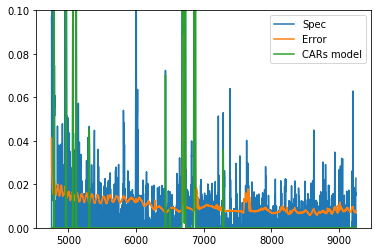

Emission lines included in gas templates:
['Hbeta' 'Halpha' '[SII]6716' '[SII]6731' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
nNLines 7 bl 7
 Best Fit:       Vel     sigma
 comp.  0:      -327        76
 comp.  1:       -32        76
chi2/DOF: 2.761
method = capfit; Jac calls: 24; Func calls: 200; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  12 / 14
Templates weights:
     0.608      13.4      1.11     0.778    0.0772     0.036      6.88       4.1      98.3      8.21      12.2      0.57     0.399      79.1
(3593, 7)
3 0


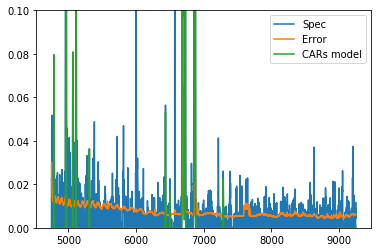

Emission lines included in gas templates:
['Hbeta' 'Halpha' '[SII]6716' '[SII]6731' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
nNLines 7 bl 7
 Best Fit:       Vel     sigma
 comp.  0:         0        50
 comp.  1:         0        50
chi2/DOF: 18.96
method = capfit; Jac calls: 1; Func calls: 20; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  7 / 14
Templates weights:
       5.9      28.2      1.47      2.01     0.725     0.224      21.7         0         0         0         0         0         0         0
(3595, 7)
3 1


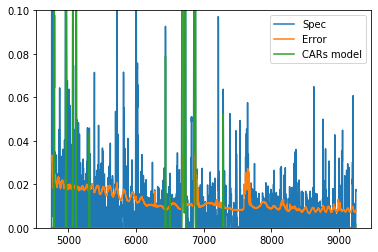

Emission lines included in gas templates:
['Hbeta' 'Halpha' '[SII]6716' '[SII]6731' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
nNLines 7 bl 7
 Best Fit:       Vel     sigma
 comp.  0:      -323        80
 comp.  1:       -23        80
chi2/DOF: 3.574
method = capfit; Jac calls: 19; Func calls: 159; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  12 / 14
Templates weights:
     0.846      18.8      1.47      1.49     0.106    0.0464      9.45      5.46       132        11      16.5     0.693     0.481       104
(3593, 7)
3 2


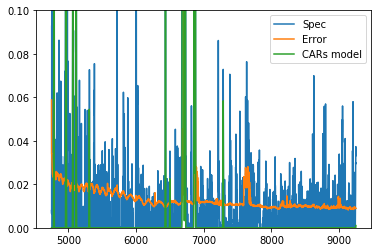

Emission lines included in gas templates:
['Hbeta' 'Halpha' '[SII]6716' '[SII]6731' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
nNLines 7 bl 7
 Best Fit:       Vel     sigma
 comp.  0:        -0        54
 comp.  1:        -0        54
chi2/DOF: 21.21
method = capfit; Jac calls: 2; Func calls: 28; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  7 / 14
Templates weights:
         0         0         0         0         0         0         0       5.2       128      9.59      15.5     0.694     0.598       112
(3595, 7)
3 3


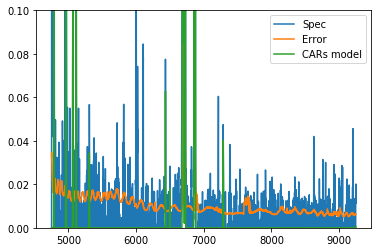

Emission lines included in gas templates:
['Hbeta' 'Halpha' '[SII]6716' '[SII]6731' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
nNLines 7 bl 7
 Best Fit:       Vel     sigma
 comp.  0:     -2000        23
 comp.  1:       -43        97
chi2/DOF: 6.787
method = capfit; Jac calls: 10; Func calls: 83; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  8 / 14
Templates weights:
         0         0    0.0291         0         0    0.0175     0.501      3.75      93.4      7.76      11.1      0.57     0.408      71.2
(3593, 7)


In [14]:
from ppxf_doubleG import ppxf_indiv

z = 0.0214

size_cut = 2
cen=155
S_N = np.mean(hdulist[0].data[:3600,cen-size_cut:cen+size_cut,cen-size_cut:cen+size_cut]/hdulist[1].data[:3600,cen-size_cut:cen+size_cut,cen-size_cut:cen+size_cut], axis=0)





cut = hdulist[0].data[:3600,cen-size_cut:cen+size_cut,cen-size_cut:cen+size_cut] - cont_model[0].data[:3600,cen-size_cut:cen+size_cut,cen-size_cut:cen+size_cut]
cut_error = hdulist[1].data[:3600,cen-size_cut:cen+size_cut,cen-size_cut:cen+size_cut]
eline_model_cut = eline_model[0].data[:3600,cen-size_cut:cen+size_cut,cen-size_cut:cen+size_cut]




xs = np.linspace(0,np.shape(hdulist[0].data)[0]-1,np.shape(hdulist[0].data)[0])
wav = [hdulist[0].header['CRVAL3'] + hdulist[0].header['CDELT3']*x for x in xs]
wave_cut = wav[:3600]

print(np.mean(hdulist[0].data[:,cen-size_cut:cen+size_cut,cen-size_cut:cen+size_cut][:3600,2,3]/hdulist[1].data[:3600,cen-size_cut:cen+size_cut,cen-size_cut:cen+size_cut][:,2,3]))

print(np.mean(hdulist[0].data[:,cen-size_cut:cen+size_cut,cen-size_cut:cen+size_cut][:,2,3]/hdulist[1].data[:,cen-size_cut:cen+size_cut,cen-size_cut:cen+size_cut][:,2,3]))

len1 = np.shape(cut)[1]
len2 = len1

vel1 = np.zeros((len1, len2))
vel2 = np.zeros((len1, len2))
sig1 = np.zeros((len1, len2))
sig2 = np.zeros((len1, len2))
chi2 = np.zeros((len1, len2))

#- cont_model[0].data[:3600,cen-size_cut:cen+size_cut,cen-size_cut:cen+size_cut]
S_N = np.median(hdulist[0].data[:3600,cen-size_cut:cen+size_cut,cen-size_cut:cen+size_cut]/hdulist[1].data[:3600,cen-size_cut:cen+size_cut,cen-size_cut:cen+size_cut], axis=0)





for i in range(len1):
    for j in range(len2):
        print(i,j)
        pix1 = i
        pix2 = j
        #if S_N[pix1,pix2] < 10:
            
        #    continue
        plt.clf()
        plt.plot(wave_cut, cut[:,pix1,pix2], label='Spec')
        plt.plot(wave_cut, cut_error[:,pix1,pix2], label='Error')
        plt.plot(wave_cut, eline_model_cut[:,pix1,pix2], label='CARs model')
        
        plt.legend()
        plt.ylim([0,0.1])
        plt.show()
        
        try:
            out_ppxf_2 = ppxf_indiv('HE0045',z,lambda_spec = wave_cut, galaxy_lin=cut[:,pix1,pix2],
              error_lin=cut_error[:,pix1,pix2],
               reflines='reflines_tex.dat',
                                cars_model=eline_model_cut[:,pix1,pix2], 
                                   plotfile='ppxf_fit/HE0045_two_'+str(pix1)+'_'+str(pix2)+'.pdf')
        except:
            chi2[i,j] = 999
            STOP
            continue
        # plotfile='ppxf_fit/HE0045_rebin_2gauss_'+str(pix1)+'_'+str(pix2)+'.pdf',
        
        vel1[i,j] = out_ppxf_2[0]
        sig1[i,j] = out_ppxf_2[1]
        vel2[i,j] = out_ppxf_2[2]
        sig2[i,j] = out_ppxf_2[3]
        chi2[i,j] = out_ppxf_2[4]
        continue
        
        '''except ValueError:
            
            try:
                print('multiply by 10')
                out_ppxf = ppxf_indiv('HE0045',z,spec_hdu=hdulist, galaxy_lin=10*rebin[:,pix1,pix2],
                  error_lin=10*rebin_error[:,pix1,pix2],
                   reflines='reflines_tex.dat', plotfile='ppxf_fit/HE0045_rebin_'+str(pix1)+'_'+str(pix2)+'.pdf')
            except ValueError:
                chi[i,j] = 999
                
                continue'''
        if out_ppxf_2[1] > out_ppxf_2[3]:
            #then comp 1 is vel1
            vel1[i,j] = out_ppxf_2[0]
            sig1[i,j] = out_ppxf_2[1]
            vel2[i,j] = out_ppxf_2[2]
            sig2[i,j] = out_ppxf_2[3]
            chi2[i,j] = out_ppxf_2[4]
        else:
            vel2[i,j] = out_ppxf_2[0]
            sig2[i,j] = out_ppxf_2[1]f
            vel1[i,j] = out_ppxf_2[2]
            sig1[i,j] = out_ppxf_2[3]
            chi2[i,j] = out_ppxf_2[4]
        
save_array_2 = np.array([vel1, vel2, sig1, sig2, chi2]).T
np.save('ppxf_fit/output_ppxf_fits_2G_small.npy', save_array_2)

#return zfit_stars, sigma_stars, sigma_blr, wave, pp.bestfit


In [29]:
#
import numpy as np
saved_kin = np.load('ppxf_fit/output_ppxf_fits_2G.npy')

print(np.shape(saved_kin))
vel1 = saved_kin[:,:,0] 
vel2 = saved_kin[:,:,1] 
sig1 = saved_kin[:,:,2] 
sig2 = saved_kin[:,:,3] 
chi2 = saved_kin[:,:,4] 

(30, 30, 5)


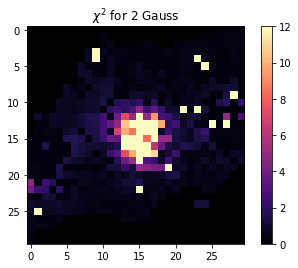

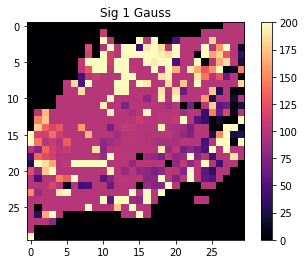

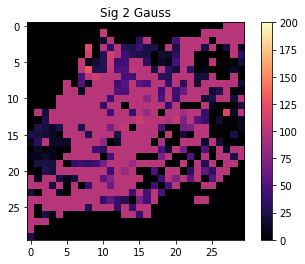

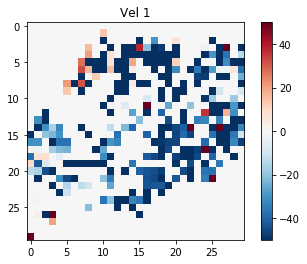

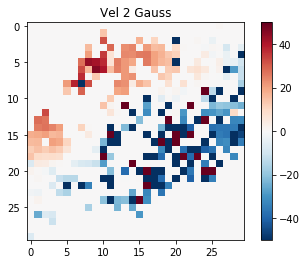

In [15]:
import matplotlib
import matplotlib.pyplot as plt
class MidpointNormalize(matplotlib.colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

    
'''plt.clf()
plt.imshow(chi1, cmap='magma', vmax = 10)
plt.colorbar()
plt.title('$\chi^2$ for 1 Gauss')
plt.show()'''

plt.clf()
plt.imshow(chi2, cmap='magma', vmax = 12)
plt.colorbar()
plt.title('$\chi^2$ for 2 Gauss')
plt.show()


plt.clf()
plt.imshow(sig1, cmap='magma', vmax=200)
plt.title('Sig 1 Gauss')
plt.colorbar()
plt.show()


plt.clf()
plt.imshow(sig2, cmap='magma', vmax=200)
plt.title('Sig 2 Gauss')
plt.colorbar()
plt.show()

plt.clf()
plt.imshow(vel1, cmap='RdBu_r', norm=MidpointNormalize(midpoint=0, vmin=-50, vmax=50))
plt.title('Vel 1')
plt.colorbar()
plt.show()

plt.clf()
plt.imshow(np.ma.masked_where(vel2>500, vel2), cmap='RdBu_r', norm=MidpointNormalize(midpoint=0, vmin=-50, vmax=50))
plt.title('Vel 2 Gauss')
plt.colorbar()
plt.show()

In [6]:
from ppxf_doubleG import ppxf_indiv
from ppxf_singleG import ppxf_single

len1 = np.shape(cut)[1]
len2 = len1

vel1 = np.zeros((len1, len2))
vel2 = np.zeros((len1, len2))
sig1 = np.zeros((len1, len2))
sig2 = np.zeros((len1, len2))
chi2 = np.zeros((len1, len2))

chi = np.zeros((len1, len2))
sig = np.zeros((len1, len2))
vel = np.zeros((len1, len2))





for i in range(len1):
    for j in range(len2):
        print(i,j)
        pix1 = i
        pix2 = j
        
        '''if np.max(rebin[:,pix1,pix2]) < 1:
            continue'''
        
        
        #try:
        out_ppxf_2 = ppxf_indiv('HE0045',z,lambda_spec = wave_cut, galaxy_lin=cut[:,pix1,pix2],
              error_lin=cut_error[:,pix1,pix2],
               reflines='reflines_tex.dat', 
                                plotfile='ppxf_fit/HE0045_rebin_2gauss_'+str(pix1)+'_'+str(pix2)+'.pdf',
                               cars_model=eline_model_cut[:,pix1,pix2])
        out_ppxf_1 = ppxf_single('HE0045',z,lambda_spec = wave_cut, galaxy_lin=cut[:,pix1,pix2],
              error_lin=cut_error[:,pix1,pix2],
               reflines='reflines_tex.dat', 
                                 plotfile='ppxf_fit/HE0045_rebin_1gauss_'+str(pix1)+'_'+str(pix2)+'.pdf',
                                cars_model=eline_model_cut[:,pix1,pix2])
        
        
        
        '''except ValueError:
            
            try:
                print('multiply by 10')
                out_ppxf = ppxf_indiv('HE0045',z,spec_hdu=hdulist, galaxy_lin=10*rebin[:,pix1,pix2],
                  error_lin=10*rebin_error[:,pix1,pix2],
                   reflines='reflines_tex.dat', plotfile='ppxf_fit/HE0045_rebin_'+str(pix1)+'_'+str(pix2)+'.pdf')
            except ValueError:
                chi[i,j] = 999
                
                continue'''
        if out_ppxf_2[1] > out_ppxf_2[3]:
            #then comp 1 is vel1
            vel1[i,j] = out_ppxf_2[0]
            sig1[i,j] = out_ppxf_2[1]
            vel2[i,j] = out_ppxf_2[2]
            sig2[i,j] = out_ppxf_2[3]
            chi2[i,j] = out_ppxf_2[4]
        else:
            vel2[i,j] = out_ppxf_2[0]
            sig2[i,j] = out_ppxf_2[1]
            vel1[i,j] = out_ppxf_2[2]
            sig1[i,j] = out_ppxf_2[3]
            chi2[i,j] = out_ppxf_2[4]
        vel[i,j] = out_ppxf_1[0]
        sig[i,j] = out_ppxf_1[1]
        chi[i,j] = out_ppxf_1[2]

#return zfit_stars, sigma_stars, sigma_blr, wave, pp.bestfit
print(out_ppxf)

0 0
FWHM 2.94293069858
Emission lines included in gas templates:
['Hbeta' 'Halpha' '[SII]6716' '[SII]6731' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
nNLines 7 bl 7
 Best Fit:       Vel     sigma
 comp.  0:       105        51
 comp.  1:       -32       206
chi2/DOF: 0.7219
method = capfit; Jac calls: 9; Func calls: 74; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  13 / 14
Templates weights:
      1.02        23      2.45      3.23     0.111     0.132      17.7     0.913      15.6      1.31      1.13     0.163     0.019      8.44
(3593, 7)
FWHM 2.94293069858
Emission lines included in gas templates:
['Hbeta' 'Halpha' '[SII]6716' '[SII]6731' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
 Best Fit:       Vel     sigma
 comp.  0:        84        96
chi2/DOF: 5.643
method = capfit; Jac calls: 13; Func calls: 80; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  7 / 7
Templates weights:
      1.73      33.4      3.89      4.57     0.219     0.175      23.9
0 1
FWHM 2.9

FWHM 2.94293092654
Emission lines included in gas templates:
['Hbeta' 'Halpha' '[SII]6716' '[SII]6731' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
 Best Fit:       Vel     sigma
 comp.  0:        77       102
chi2/DOF: 9.356
method = capfit; Jac calls: 14; Func calls: 86; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  7 / 7
Templates weights:
      4.23      86.8      8.15      11.4     0.562     0.458      64.5
2 1
FWHM 2.94293092654
Emission lines included in gas templates:
['Hbeta' 'Halpha' '[SII]6716' '[SII]6731' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
nNLines 7 bl 7
 Best Fit:       Vel     sigma
 comp.  0:       100        47
 comp.  1:         2       193
chi2/DOF: 1.43
method = capfit; Jac calls: 17; Func calls: 138; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  14 / 14
Templates weights:
      4.59      65.5      3.77       6.5     0.569     0.335        58      4.05      49.7      2.97      2.79     0.678     0.351        29
(3594, 7)
FWHM 2.94293

NameError: name 'out_ppxf' is not defined

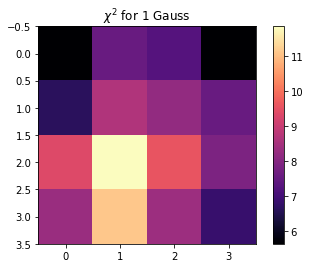

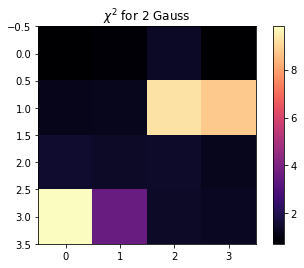

In [11]:
import matplotlib
import numpy.ma as ma
c=3e5
plt.clf()
plt.imshow(chi, cmap='magma')
plt.colorbar()
plt.title('$\chi^2$ for 1 Gauss')
plt.show()

plt.clf()
plt.imshow(chi2, cmap='magma')
plt.colorbar()
plt.title('$\chi^2$ for 2 Gauss')
plt.show()



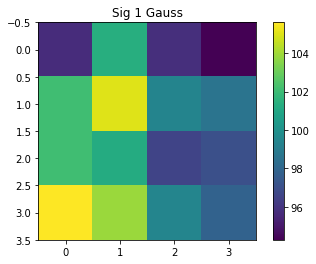

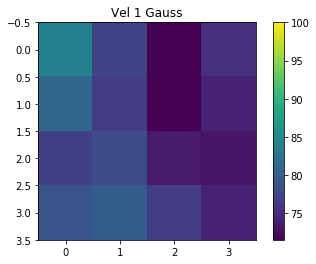

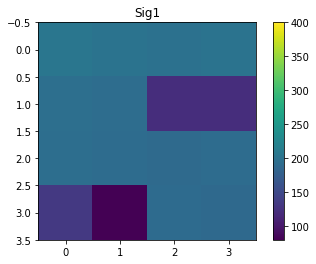

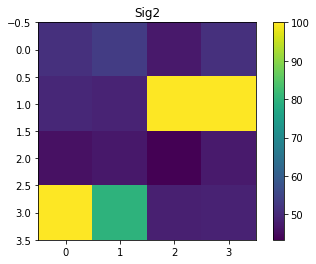

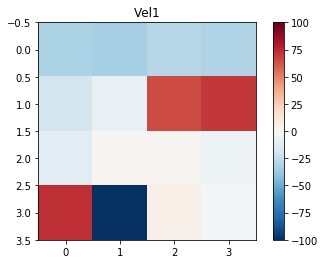

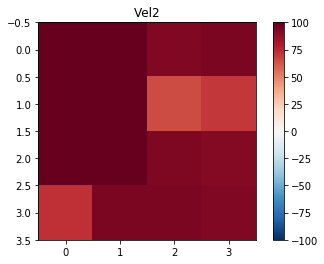

In [15]:

plt.clf()
plt.imshow(sig)
plt.title('Sig 1 Gauss')
plt.colorbar()
plt.show()
plt.clf()
plt.imshow(vel, vmax=100)
plt.title('Vel 1 Gauss')
plt.colorbar()
plt.show()



plt.clf()
plt.imshow(sig1, vmax=400)
plt.title('Sig1')
plt.colorbar()
plt.show()
plt.clf()
plt.imshow(sig2, vmax=100)
plt.title('Sig2')
plt.colorbar()
plt.show()
           
plt.clf()
plt.imshow(vel1, cmap='RdBu_r', vmin=-100, vmax=100)#, vmin=-300, vmax=300)
plt.title('Vel1')
plt.colorbar()
plt.show()
plt.clf()
plt.imshow(vel2, cmap='RdBu_r', vmin=-100, vmax=100)#, vmin=-300, vmax=300)
plt.title('Vel2')
plt.colorbar()
plt.show()

### Rebinning
Rebin in order to have higher S/N per spaxel

In [6]:
import scipy


end_cut = 3600
galaxy = hdulist[0].data[:end_cut,cen-size_cut:cen+size_cut,cen-size_cut:cen+size_cut] - cont_model[0].data[:end_cut,cen-size_cut:cen+size_cut,cen-size_cut:cen+size_cut]
galaxy_error = hdulist[1].data[:end_cut,cen-size_cut:cen+size_cut,cen-size_cut:cen+size_cut]
zoom_factor = 4

from skimage.measure import block_reduce
rebin = block_reduce(galaxy, block_size=(1, zoom_factor, zoom_factor), func=np.sum)
rebin_error = block_reduce(galaxy_error, block_size=(1, zoom_factor, zoom_factor), func=np.sum)

print(np.shape(galaxy), np.shape(rebin))

#rebin = np.zeros((np.shape(galaxy)[0],int(np.shape(galaxy)[1]/2),int(np.shape(galaxy)[1]/2) ))
#for j in range(np.shape(galaxy)[0]):
#    rebin[j,:,:] = shrink(galaxy[j,:,:],int(np.shape(galaxy)[1]/2),int(np.shape(galaxy)[1]/2 ))



(3600, 40, 40) (3600, 10, 10)


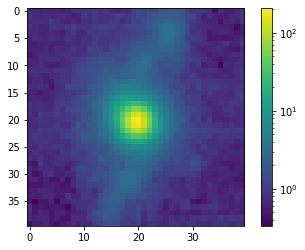

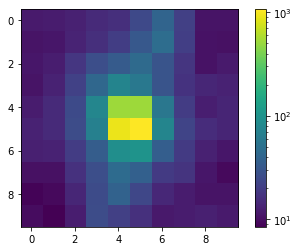

0.25
summing this many spaxels (3600, 4, 4)


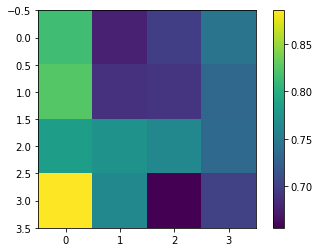

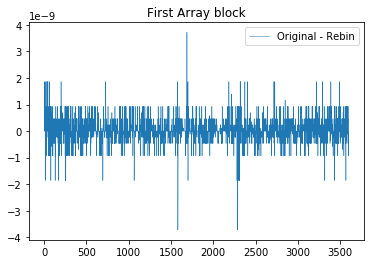

In [7]:
import matplotlib

plt.clf()
plt.imshow(np.sum(galaxy, axis=0), norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.show()

plt.clf()
plt.imshow(np.sum(rebin, axis=0), norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.show()
print(1/zoom_factor)
print('summing this many spaxels', np.shape(galaxy[:,0:int(zoom_factor),0:int(zoom_factor)]))
plt.clf()
plt.imshow(np.sum(galaxy[:,0:int(zoom_factor),0:int(zoom_factor)], axis=0))
plt.colorbar()
plt.show()

'''plt.clf()
plt.imshow(np.sum(rebin[:,0,0], axis=0))
plt.colorbar()
plt.show()'''

plt.clf()
plt.title('First Array block')
plt.plot(np.sum(galaxy[:,0:int(zoom_factor),0:int(zoom_factor)], axis=(1,2)) - rebin[:,0,0], 
         label='Original - Rebin', lw=0.5)
#plt.plot(rebin[:,0,0], label='Rebin', lw=0.5)
plt.legend()
plt.show()


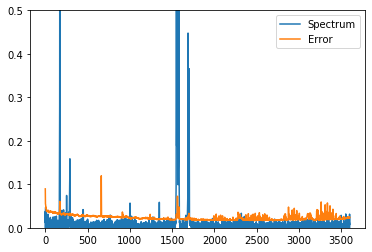

0.11943565

In [8]:
plt.clf()
plt.plot(rebin[:,3,3], label='Spectrum')
plt.plot(rebin_error[:,3,3], label='Error')
plt.ylim([0,0.5])
plt.legend()
plt.show()

np.median(rebin[:,3,3]/rebin_error[:,3,3])

In [9]:
from ppxf_doubleG import ppxf_indiv
from ppxf_singleG import ppxf_single

len1 = np.shape(rebin)[1]
len2 = len1

vel1 = np.zeros((len1, len2))
vel2 = np.zeros((len1, len2))
sig1 = np.zeros((len1, len2))
sig2 = np.zeros((len1, len2))
chi2 = np.zeros((len1, len2))

chi = np.zeros((len1, len2))
sig = np.zeros((len1, len2))
vel = np.zeros((len1, len2))





for i in range(len1):
    for j in range(len2):
        print(i,j)
        pix1 = i
        pix2 = j
        
        '''if np.max(rebin[:,pix1,pix2]) < 1:
            continue'''
        
        
        #try:
        out_ppxf_2 = ppxf_indiv('HE0045',z,spec_hdu=hdulist, galaxy_lin=rebin[:,pix1,pix2],
              error_lin=rebin_error[:,pix1,pix2],
               reflines='reflines_tex.dat', plotfile='ppxf_fit/HE0045_rebin_2_'+str(pix1)+'_'+str(pix2)+'.pdf')
        out_ppxf_1 = ppxf_single('HE0045',z,spec_hdu=hdulist, galaxy_lin=rebin[:,pix1,pix2],
              error_lin=rebin_error[:,pix1,pix2],
               reflines='reflines_tex.dat', plotfile='ppxf_fit/HE0045_rebin_1_'+str(pix1)+'_'+str(pix2)+'.pdf')
        '''except ValueError:
            
            try:
                print('multiply by 10')
                out_ppxf = ppxf_indiv('HE0045',z,spec_hdu=hdulist, galaxy_lin=10*rebin[:,pix1,pix2],
                  error_lin=10*rebin_error[:,pix1,pix2],
                   reflines='reflines_tex.dat', plotfile='ppxf_fit/HE0045_rebin_'+str(pix1)+'_'+str(pix2)+'.pdf')
            except ValueError:
                chi[i,j] = 999
                
                continue'''
        if out_ppxf_2[1] > out_ppxf_2[3]:
            #then comp 1 is vel1
            vel1[i,j] = out_ppxf_2[0]
            sig1[i,j] = out_ppxf_2[1]
            vel2[i,j] = out_ppxf_2[2]
            sig2[i,j] = out_ppxf_2[3]
            chi2[i,j] = out_ppxf_2[4]
        else:
            vel2[i,j] = out_ppxf_2[0]
            sig2[i,j] = out_ppxf_2[1]
            vel1[i,j] = out_ppxf_2[2]
            sig1[i,j] = out_ppxf_2[3]
            chi2[i,j] = out_ppxf_2[4]
        vel[i,j] = out_ppxf_1[0]
        sig[i,j] = out_ppxf_1[1]
        chi[i,j] = out_ppxf_1[2]

#return zfit_stars, sigma_stars, sigma_blr, wave, pp.bestfit
print(out_ppxf)

0 0
0 1
0 2
0 3
0 4
FWHM 2.94293115438
Emission lines included in gas templates:
['Hbeta' 'Halpha' '[SII]6716' '[SII]6731' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
nNLines 7 bl 7
 Best Fit:       Vel     sigma
 comp.  0:       302        23
 comp.  1:       143        23
chi2/DOF: 0.06317
method = capfit; Jac calls: 15; Func calls: 125; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  11 / 14
Templates weights:
         0     0.136   0.00378    0.0285    0.0245         0    0.0498      0.25      5.01     0.851     0.596    0.0456     0.153         2
FWHM 2.94293115438
Emission lines included in gas templates:
['Hbeta' 'Halpha' '[SII]6716' '[SII]6731' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
 Best Fit:       Vel     sigma
 comp.  0:       145        27
chi2/DOF: 0.06475
method = capfit; Jac calls: 8; Func calls: 54; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  7 / 7
Templates weights:
      5.99       2.4     0.386     0.271     0.224    0.0822      0.95
0 

ValueError: array must not contain infs or NaNs

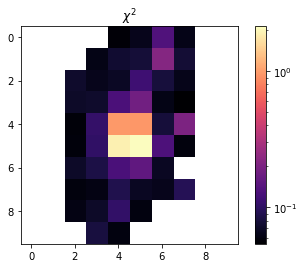

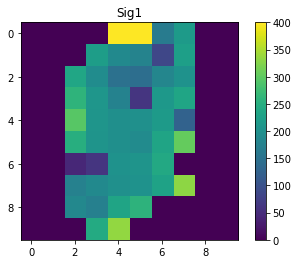

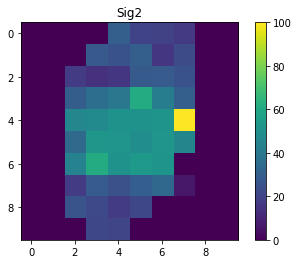

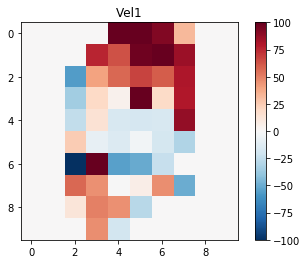

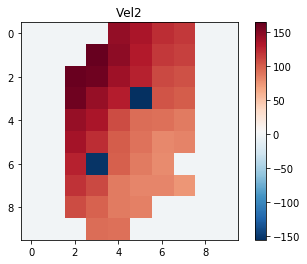

In [10]:
import matplotlib
import numpy.ma as ma
c=3e5
chi_mask = np.ma.masked_where(chi==999, chi)
chi_mask = ma.masked_where(chi_mask > 10, chi_mask)
plt.clf()
plt.imshow(chi_mask, cmap='magma',norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.title('$\chi^2$')
plt.show()

plt.clf()
plt.imshow(sig1, vmax=400)
plt.title('Sig1')
plt.colorbar()
plt.show()
plt.clf()
plt.imshow(sig2, vmax=100)
plt.title('Sig2')
plt.colorbar()
plt.show()
           
plt.clf()
plt.imshow(vel1, cmap='RdBu_r', vmin=-100, vmax=100)#, vmin=-300, vmax=300)
plt.title('Vel1')
plt.colorbar()
plt.show()
plt.clf()
plt.imshow(vel2, cmap='RdBu_r')#, vmin=-300, vmax=300)
plt.title('Vel2')
plt.colorbar()
plt.show()

In [7]:
#136 144
pix1 = 136
pix2 = 144
out_ppxf = ppxf_indiv('HE0045',z,spec_hdu=hdulist, galaxy_lin=hdulist[0].data[:,pix2,pix1],
                  error_lin=hdulist[1].data[:,pix1,pix2],plotfile='ppxf_fit/HE0045_'+str(pix1)+'_'+str(pix2)+'.pdf',
                   reflines='reflines_tex.dat')

FWHM 2.9429491974972795
Emission lines included in gas templates:
['Hbeta' 'Halpha' '[SII]6716' '[SII]6731' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
nNLines 7 bl 7
reg_dim (7,)
 Best Fit:       Vel     sigma
 comp.  0:        91       157
 comp.  1:        91       158
chi2/DOF: 0.7515
method = capfit; Jac calls: 6; Func calls: 55; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  7 / 14
Templates weights:
         0    0.0764    0.0251    0.0183         0         0    0.0797   0.00795         0         0         0    0.0103    0.0311         0


In [1]:
import matplotlib
plt.clf()

plt.plot(wav, np.sum(hdulist[0].data, axis=(1,2)))
plt.title('Summed Spectrum')
plt.ylabel(str(hdulist[0].header['BUNIT']))
plt.xlim([6650, 6750])
plt.show()

plt.clf()
#xs, ys = np.histogram(np.sum(hdulist[0].data, axis=(1,2)), bins = wav)
plt.step(wav, np.sum(hdulist[0].data, axis=(1,2)), color='black')
#plt.scatter(ys[:-1],xs, color='black')
plt.title('Summed Spectrum')
plt.ylabel(str(hdulist[0].header['BUNIT']))
#plt.xlim([6650, 6750])
plt.show()

plt.clf()

plt.step(wav, hdulist[0].data[:,150,150], color='black')
#plt.plot(wav, hdulist[0].data[:,140,150])
plt.title('Individual Spaxels')
plt.ylabel(str(hdulist[0].header['BUNIT']))
plt.xlim([6650, 6750])
plt.show()

plt.imshow(np.sum(hdulist[0].data, axis=0), norm=matplotlib.colors.LogNorm())
plt.show()



NameError: name 'plt' is not defined

In [ ]:
# Fit a Gauss to this:
import scipy

def one_gauss_fit(x, a, mu, sigma):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))
def two_gauss_fit(x, a, mu, sigma, a2, mu2, sigma2):
    return a*np.exp(-(x-mu)**2/(2*sigma**2)) + a2*np.exp(-(x-mu2)**2/(2*sigma2**2)) 
def linefit(x,m,b):
 
    return [m*i + b for i in x]


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]




def fit_gaussians_aik(wav, data, error, pix_x, pix_y , guess_mu):

    print(np.min(data))

    

    # first, fit a line:
    print(np.shape(wav), np.shape(data))
    poptline, pcov = scipy.optimize.curve_fit(linefit, wav, data, p0=[0.1,np.min(data)])
    print(poptline)
    line = linefit(wav, *poptline)
    #line = [line_y for x in wav[idx_1:idx_2]]
    
    guess = [np.max(data), guess_mu, 5]
    popt, pcov = scipy.optimize.curve_fit(one_gauss_fit, wav,data, p0=guess)
    print('best fit for 1 gauss', popt)
    gauss_1 = one_gauss_fit(wav, *popt)

    # Now fit 2 Gauss
    guess2 = [popt[0]/2, popt[1], popt[2], popt[0]/2, popt[1]-2, popt[2]]
    try:
        popt2, pcov2 = scipy.optimize.curve_fit(two_gauss_fit, wav,data, p0=guess2)
    except:
        plt.clf()
        plt.step(wav, data)
        plt.show()
        return 0, 0
    
    gauss_2_1 = one_gauss_fit(wav, *[popt2[0], popt2[1], popt2[2]])
    gauss_2_2 = one_gauss_fit(wav, *[popt2[3], popt2[4], popt2[5]])
    gauss_2 = two_gauss_fit(wav, *popt2)

    chi_line = np.sum(abs(line - data)**2/error**2)
    chi_1 = np.sum(abs(gauss_1 - data)**2/error**2)
    chi_2 = np.sum(abs(gauss_2 - data)**2/error**2)

    n = idx_2 - idx_1

    k = 2
    aik_line = chi_line + 2*k + 2*k*(k+1)/(n - k - 1)
    
    k = 3
    aik_1 = chi_1 + 2*k + 2*k*(k+1)/(n - k - 1)

    k = 6
    aik_2 = chi_2 + 2*k + 2*k*(k+1)/(n - k - 1)
    #AIC = chi +2k
    #AIC + 2k(k + 1)/(n − k − 1)

    plt.clf()
    plt.plot(wav, line, color='blue')
    plt.step(wav, data, color='black', where='mid', label='Data')
    plt.scatter(wav, data, color='black', s=5)
    plt.step(wav, one_gauss_fit(wav, *popt), color='red', label='1 Gauss', where='mid')
    #plt.step(wav[idx_1:idx_2], two_gauss_fit(wav[idx_1:idx_2], *popt2), color='orange', label='2 Gauss')#, where='mid')
    plt.step(wav, gauss_2_1, color='orange', where='mid', label='2 Gauss')
    plt.step(wav, gauss_2_2, color='orange', where='mid')


    plt.title('Individual Spaxels')
    plt.ylabel(str(hdulist[0].header['BUNIT']))
    plt.legend(loc='upper center', bbox_to_anchor=(1.15, 0.8))
    plt.annotate('$AIK_1$ = '+str(round(aik_1,1)), xy=(0.05, 0.95), xycoords='axes fraction', color='red')
    plt.annotate('$AIK_2$ = '+str(round(aik_2,1)), xy=(0.05, 0.9), xycoords='axes fraction', color='orange')
    
    if aik_line < aik_1 and aik_line < aik_2:
        plt.annotate('Line is best', xy=(0.05, 0.85), xycoords='axes fraction', color='black')
        fit = 0
        fit_param = poptline
    else:
        if aik_2 < aik_1:
            plt.annotate('Two is best', xy=(0.05, 0.85), xycoords='axes fraction', color='black')
            fit = 2
            fit_param = popt2
            
        else:
            plt.annotate('One is best', xy=(0.05, 0.85), xycoords='axes fraction', color='black')
            fit = 1
            fit_param = popt
           

    #plt.xlim([6650, 6750])
    plt.show()

    
    #data, error, gauss_1, gauss_2, gauss_2_1, gauss_2_2, aik_line, aik_1, aik_2,
    return fit, fit_param

start_x = 6712
end_x = 6732
mu = 6723

idx_1 = find_nearest(wav, start_x)[0]
idx_2 = find_nearest(wav, end_x)[0]

wavecut = wav[idx_1:idx_2]

fit_n = np.zeros((len(hdulist[0].data[1]),len(hdulist[0].data[2])))
vel_narrow = np.zeros((len(hdulist[0].data[1]),len(hdulist[0].data[2])))
vel_broad = np.zeros((len(hdulist[0].data[1]),len(hdulist[0].data[2])))
sig_narrow = np.zeros((len(hdulist[0].data[1]),len(hdulist[0].data[2])))
sig_broad = np.zeros((len(hdulist[0].data[1]),len(hdulist[0].data[2])))

for j in range(len(hdulist[0].data[1])):
    for i in range(len(hdulist[0].data[2])):
        # For each row, quickly do a S/N calculation to see if you even try to fit it
        if np.all(hdulist[0].data[idx_1:idx_2, j, i]) ==0.0:
            continue
        data = hdulist[0].data[:,j,i][idx_1:idx_2] - cont_model[0].data[:,j,i][idx_1:idx_2]
        error = hdulist[1].data[:,j,i][idx_1:idx_2]
        
        S_N = data/error
        if np.median(S_N) < 5:#was 10
            continue
            
        '''plt.clf()
        plt.step(wav[idx_1:idx_2],data, label='Data')
        plt.step(wav[idx_1:idx_2],error, label='Noise')
        plt.legend()
        plt.title('j = '+str(j)+', i = '+str(i))
        plt.show()'''
        
        
        out = fit_gaussians_aik(wavecut, data, error, j,i, mu)
        fit_n[j,i] = out[0]
        if out[0] ==2:
            vel_narrow[j,i] = out[1][1]
            sig_narrow[j,i] = out[1][2]
            vel_broad[j,i] = out[1][4]
            sig_broad[j,i] = out[1][5]
        if out[0] ==1:
            vel_narrow[j,i] = out[1][1]
            sig_narrow[j,i] = out[1][2]
            
        #if out


In [2]:
print(fit_n)

class MidpointNormalize(matplotlib.colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


colorsList = ['#feb922','#e6d1fc','#2ec4b6']
CustomCmap = matplotlib.colors.ListedColormap(colorsList)

plt.clf()
fig = plt.figure()
ax0 = fig.add_subplot(121)
im0 = ax0.imshow(np.sum(hdulist[0].data, axis=0), norm = matplotlib.colors.LogNorm())
plt.colorbar(im0, label='Summed Flux',fraction = 0.046)

ax1 = fig.add_subplot(122)
im1 = ax1.imshow(fit_n, cmap=CustomCmap)#'Set2')
plt.colorbar(im1, label='# Gaussian Components',fraction = 0.046)
plt.tight_layout()
plt.savefig('n_comps.png', dpi=1000)


plt.clf()
fig = plt.figure()
ax0 = fig.add_subplot(121)
im0 = ax0.imshow(np.ma.masked_where(vel_broad==0, vel_broad), cmap='RdBu_r', norm=MidpointNormalize(midpoint=cz.value))
plt.colorbar(im0, label='Velocity Broad',fraction = 0.046)

ax1 = fig.add_subplot(122)
im1 = ax1.imshow(np.ma.masked_where(vel_narrow==0, vel_narrow)-cz.value)
plt.colorbar(im1, label='Velocity Narrow',fraction = 0.046)
plt.tight_layout()
plt.show()
#plt.savefig('vel_comps.png', dpi=1000)

plt.clf()
fig = plt.figure()
ax0 = fig.add_subplot(121)
im0 = ax0.imshow(sig_broad)
plt.colorbar(im0, label='Sigma Broad',fraction = 0.046)

ax1 = fig.add_subplot(122)
im1 = ax1.imshow(sig_narrow, vmin=0)
plt.colorbar(im1, label='Sigma Narrow',fraction = 0.046)
plt.tight_layout()
plt.show()
#plt.savefig('sig_comps.png', dpi=1000)

NameError: name 'fit_n' is not defined

Read in the image data and header:

In [295]:
data = hdulist[0].data
header = hdulist[0].header
hdulist.close()

I want to make a movie that steps through the velocity structures of the H-alpha + [N II] emission lines. Let's find roughly where that is in the cube. 

In [296]:
ha_wavelength_at_z = 6563*u.AA * (1+z)
ha_wavelength_at_z

<Quantity 6700.823 Angstrom>

Let's first identify (roughly) which spectral channel in the MUSE cube this wavelength corresponds to. Note that the spectral axis of the MUSE cube is not "automatically" in units of wavelength. One needs to convert the spectral axis to a wavelength array using the dispersion information encoded in the FITS header, following the standard FITS `CRPIX / CRDEL` keywords. 

How do we do this? 

First, let's take a look at the shape of the cube itself:

In [297]:
np.shape(data)

(3682, 314, 319)

There are 3681 spectral elements (channels), and 219x220 spatial elements (e.g. RA, Dec "pixels" across the FOV, if you will). This is smaller than the native MUSE pixel resolution because we've binned up the data to increase S/N. 

In [298]:
number_of_channels = len(data[:,0,0])
number_of_channels

3682

You might not be familiar with how the wavelength axis is encoded in MUSE data (or all FITS images, for that matter). By the FITS standard, we encode the dispersion thusly: 
```
CUNIT3  = 'Angstrom'
CD3_3   = 1.25
CRPIX3  = 1.
CRVAL3  = 4749.70068359375    
```

__This is how you create a wavelength array__:

In [299]:
wavelength = ((np.arange(number_of_channels) + 1.0) - header['CRPIX3']) * header['CD3_3'] + header['CRVAL3']
wavelength

array([4750.38134766, 4751.63134766, 4752.88134766, ..., 9349.13134766,
       9350.38134766, 9351.63134766])

That looks better! We now have a wavelength array. Let's find which channel number corresponds to the redshifted wavelength of H$\alpha$ for this source. 

In [300]:
# This quick one liner finds the element in the wavelength array 
# that is closest to the "target" wavelength, then returns that element's 
# index. 

# It finds the deviation between each array element and the target value, 
# takes its absolute value, and then returns the index of 
# the element with the smallest value in the resulting array. 
# This is the number that is closest to the target. 

ha_channel = (np.abs(wavelength - ha_wavelength_at_z.value)).argmin()
ha_channel

1560

So we know that the H$\alpha$ line centroid should be somewhat close to the above channel. It probably won't be exact, because the emission line redshift can sometimes differ a bit from the redshift reported in NED. But it'll be very close. 

Let's plot this channel:


First, though, we'll make a temporary directory to store our movie "frames" in: 

In [301]:
temp_movie_dir = "movie/"

if not os.path.exists(temp_movie_dir):
    os.makedirs(temp_movie_dir)

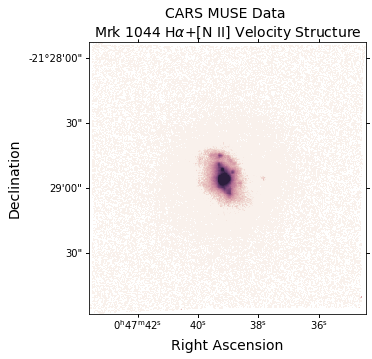

In [302]:
image = data[ha_channel,:,:]

image[image == 0] = np.nan # The reprojection makes the "background" equal to zero, which then gets mapped by the colormap. Prevent this! 

fig = plt.figure(figsize=(5,5))
ax = plt.subplot(projection=wcs)

ax.coords[0].set_axislabel('Right Ascension', fontsize=fontsize)
ax.coords[1].set_axislabel('Declination', fontsize=fontsize)

ax.set_title("CARS MUSE Data \n" r'Mrk 1044 H$\alpha$+[N II] Velocity Structure', fontsize=fontsize)


cmap = sns.cubehelix_palette(20, light=0.95,dark=0.15, as_cmap=True)
cmap.set_bad('white',1)


frame = ax.imshow(image, origin='lower', norm=LogNorm(), vmin=0.0045, vmax=0.15, cmap=cmap, interpolation='None')


We can do a *very* rough continuum subtraction, too. We know, for example, that 200 spectral channels blueward of the H$\alpha$ peak will always land in a line-free region of the continuum. We're only showing one channel at a time, so let's just subtract this smooth continuum-only channel from every frame of our movie, i.e.: 

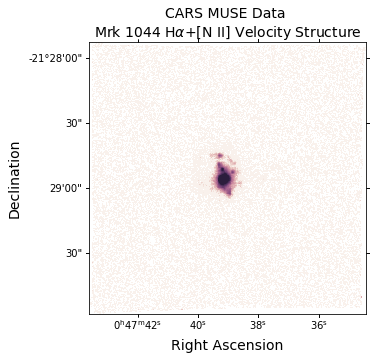

In [303]:
cont_sub_image = data[ha_channel,:,:] - data[ha_channel - 200,:,:]


cont_sub_image[cont_sub_image == 0] = np.nan # The reprojection makes the "background" equal to zero, which then gets mapped by the colormap. Prevent this! 


fig = plt.figure(figsize=(5,5))
ax = plt.subplot(projection=wcs)

ax.coords[0].set_axislabel('Right Ascension', fontsize=fontsize)
ax.coords[1].set_axislabel('Declination', fontsize=fontsize)

ax.set_title("CARS MUSE Data \n" r'Mrk 1044 H$\alpha$+[N II] Velocity Structure', fontsize=fontsize)


cmap = sns.cubehelix_palette(20, light=0.95,dark=0.15, as_cmap=True)
cmap.set_bad('white',1)


frame = ax.imshow(cont_sub_image, origin='lower', norm=LogNorm(), vmin=0.0045, vmax=0.15, cmap=cmap, interpolation='None')


Not bad for a cheap continuum subtraction, right?! 

#### Now, we can make the movie! 

Hopefully the stuff below is pretty straightforward. Again, let me know if you don't understand something!

In [304]:
### How long do you want each movie? 
channels_to_show = 30 # <-- Change me
####################################

movie_start = ha_channel - channels_to_show
movie_end = ha_channel + channels_to_show


slices_of_interest = np.arange(movie_start, movie_end, 1)
png_files = []

# Clean the temporary movie directory first
# If you don't remove all "old" movie frames, your gif is gonna be messed up. 
for f in glob.glob(temp_movie_dir + "*.png"):
    os.remove(f)

for i, slice in enumerate(slices_of_interest):
    cont_sub_image = data[slice,:,:] - data[ha_channel - 200,:,:]
    cont_sub_image[cont_sub_image == 0] = np.nan
    fig = plt.figure(figsize=(5,5))
    ax = plt.subplot(projection=wcs)
    ax.coords[0].set_axislabel('Right Ascension', fontsize=fontsize)
    ax.coords[1].set_axislabel('Declination', fontsize=fontsize)
    ax.set_title(r'CARS: Mrk 1044 H$\alpha$+[N II] Velocity Structure', fontsize=12)
    cmap = sns.cubehelix_palette(20, light=0.95,dark=0.15, as_cmap=True)
    cmap.set_bad('white',1)
    frame = ax.imshow(cont_sub_image, origin='lower', norm=LogNorm(), vmin=0.0045, vmax=0.15, cmap=cmap, interpolation='None')
    fig.savefig('movie/' + '{}'.format(i) + '.png', bbox_inches='tight', dpi=100, pad_inches=0)
    png_files.append('movie/' + '{}'.format(i) + '.png')
    plt.close(fig) # don't spam me with a gajillion figures

In [306]:
gif_name = 'images/movie.gif'

gif_frames = []

# Remove any old GIFs you might have made
if os.path.isfile(gif_name):
    os.remove(gif_name)

for filename in png_files:
    gif_frames.append(imageio.imread(filename))

imageio.mimsave(gif_name, gif_frames)



FileNotFoundError: The directory '/Users/beckynevin/CfA_Code/CARS_data/images' does not exist

In [ ]:
import random
__counter__ = random.randint(0,2e9)

from IPython.display import HTML, display
display(HTML('<img src={}>'.format(gif_name)))

The movie should look like this: 

![Learn to make this movie](images/movie.gif)


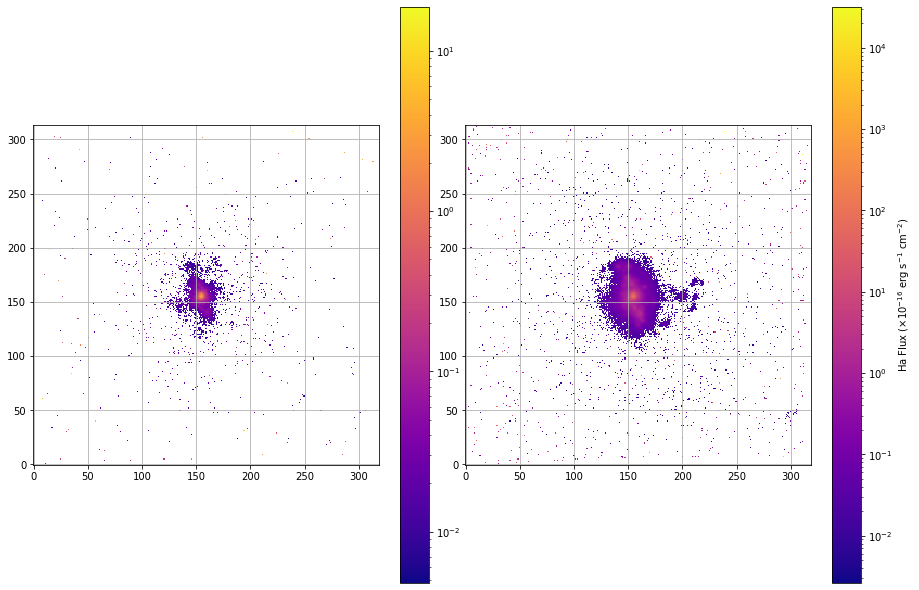

In [307]:
'''Now Becky wants to do the same thing for OIII and plot side by side with Halpha'''

gas_select = (OIII5007_flux / OIII5007_flux_err > 3)

OIII_flux_map = np.full((dim[0],dim[1]) ,np.nan)
OIII_flux_map[eline_y_cor[gas_select],eline_x_cor[gas_select]] = OIII5007_flux[gas_select]

fig = plt.figure()

ax = plt.axes([0,0,1,2])

ax.grid('off')


cmap = cm.plasma
cmap.set_bad('white',1) # Make the NANs white

frame = plt.imshow(OIII_flux_map, origin='lower', cmap=cmap, norm=LogNorm(), interpolation='None')
cbar1 = plt.colorbar()
cbar1.set_label(r"[OIII]5007 Flux ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$)")
ax.set_label('OIII')

ax1 = plt.axes([1,0,1,2])

ax1.grid('off')


cmap = cm.plasma
cmap.set_bad('white',1) # Make the NANs white

frame = plt.imshow(Ha_flux_map, origin='lower', cmap=cmap, norm=LogNorm(), interpolation='None')
cbar = plt.colorbar()
ax1.set_label('Halpha')
cbar.set_label(r"Ha Flux ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$)")

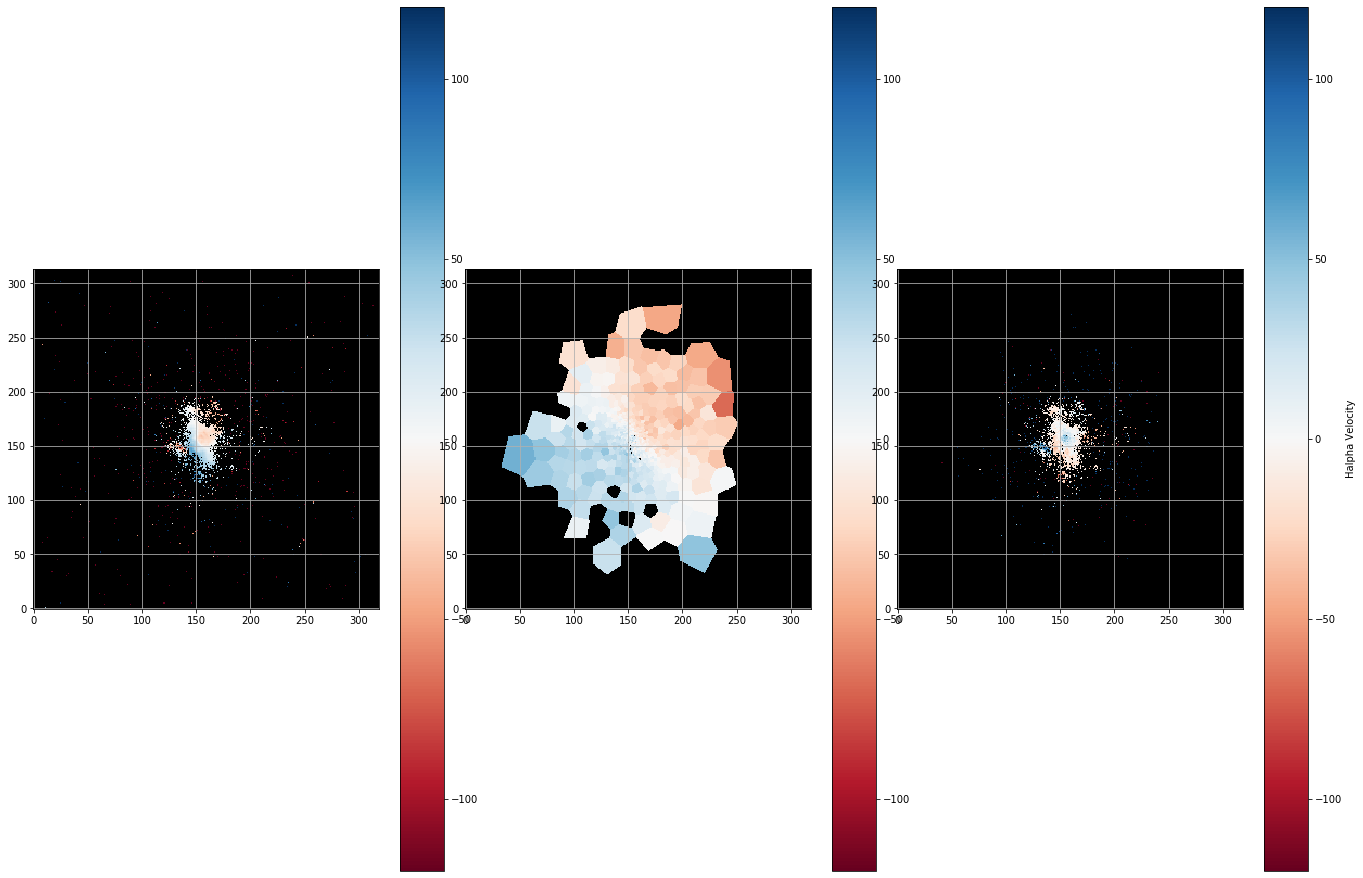

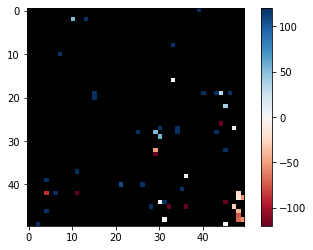

In [308]:
median_OIII_vel = np.median(OIII5007_vel[gas_select])

OIII_vel_map = np.full((dim[0],dim[1]) ,np.nan)
OIII_vel_map[eline_y_cor[gas_select],eline_x_cor[gas_select]] = OIII5007_vel[gas_select] - median_OIII_vel

fig = plt.figure()

ax = plt.axes([0,0,1,3])

ax.grid('off')


cmap = cm.RdBu
cmap.set_bad('black',1)

frame = plt.imshow(OIII_vel_map, origin='lower', cmap=cmap, vmin=-120, vmax=120, interpolation='None')
cbar = plt.colorbar()
cbar.set_label(r"OIII Velocity")

ax1 = plt.axes([1,0,1,3])

ax1.grid('off')


cmap = cm.RdBu
cmap.set_bad('black',1)

frame = plt.imshow(stellar_vel_map, origin='lower', cmap=cmap, vmin=-120, vmax=120, interpolation='None')
cbar = plt.colorbar()
cbar.set_label(r"Halpha Velocity")


ax2 = plt.axes([2,0,1,3])

ax2.grid('off')


cmap = cm.RdBu
cmap.set_bad('black',1)

frame = plt.imshow(stellar_vel_map-OIII_vel_map, origin='lower', cmap=cmap, vmin=-120, vmax=120, interpolation='None')
cbar = plt.colorbar()
cbar.set_label(r"Halpha Velocity")

plt.show()

plt.clf()
plt.imshow((stellar_vel_map-OIII_vel_map)[75:125,75+25:125+25], cmap=cmap, vmin=-120, vmax=120)
plt.colorbar()
plt.show()

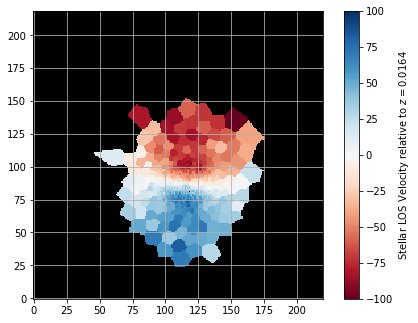

In [71]:
fig = plt.figure()

ax = plt.axes([0,0,1,1])
ax.grid('off')

cmap = cm.RdBu
cmap.set_bad('black',1) # I make the NANs black here because white is included in my colormap, encoding values near zero

frame = plt.imshow(stellar_vel_map, origin='lower', cmap=cmap, vmin=-100, vmax=100, interpolation='None')
cbar = plt.colorbar()
cbar.set_label(r"Stellar LOS Velocity relative to $z=0.0164$")

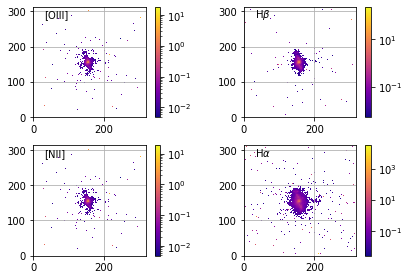

In [309]:
'''What about making BPT ratios?'''

gas_select = (NII6583_flux / NII6583_flux_err > 3)

NII_flux_map = np.full((dim[0],dim[1]) ,np.nan)
NII_flux_map[eline_y_cor[gas_select],eline_x_cor[gas_select]] = NII6583_flux[gas_select]

gas_select = (Hb_flux / Hb_flux_err > 3)

Hb_flux_map = np.full((dim[0],dim[1]) ,np.nan)
Hb_flux_map[eline_y_cor[gas_select],eline_x_cor[gas_select]] = Hb_flux[gas_select]


fig = plt.figure()

ax = fig.add_subplot(221)

ax.grid('off')


cmap = cm.plasma
cmap.set_bad('white',1) # Make the NANs white

frame = plt.imshow(OIII_flux_map, origin='lower', cmap=cmap, norm=LogNorm(), interpolation='None')
cbar1 = plt.colorbar()

ax.annotate('[OIII]', xy=(0.1,0.9), xycoords='axes fraction')


ax1 = fig.add_subplot(222)

ax1.grid('off')


cmap = cm.plasma
cmap.set_bad('white',1) # Make the NANs white

frame = plt.imshow(Hb_flux_map, origin='lower', cmap=cmap, norm=LogNorm(), interpolation='None')
cbar = plt.colorbar()
ax1.annotate(r'H$\beta$', xy=(0.1,0.9), xycoords='axes fraction')

ax2 = fig.add_subplot(223)

ax2.grid('off')


cmap = cm.plasma
cmap.set_bad('white',1) # Make the NANs white

frame = plt.imshow(NII_flux_map, origin='lower', cmap=cmap, norm=LogNorm(), interpolation='None')
cbar2 = plt.colorbar()
#cbar1.set_label(r"[OIII]5007 Flux ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$)")
#ax.set_label('OIII')
ax2.annotate('[NII]', xy=(0.1,0.9), xycoords='axes fraction')


ax3 = fig.add_subplot(224)

ax3.grid('off')


cmap = cm.plasma
cmap.set_bad('white',1) # Make the NANs white

frame = plt.imshow(Ha_flux_map, origin='lower', cmap=cmap, norm=LogNorm(), interpolation='None')
cbar = plt.colorbar()
ax3.annotate(r'H$\alpha$', xy=(0.1,0.9), xycoords='axes fraction')

plt.tight_layout()
plt.show()



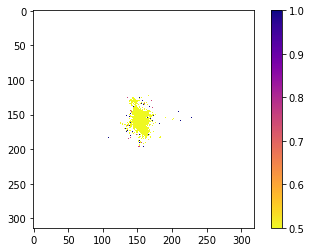

In [310]:
import math
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#Kewley: log([O III]/Hβ) < 0.61/[log([N II]/Hα) − 0.05] + 1.3
xs_kew = np.linspace(-2,0,100)
ys_kew = [0.61/(x-0.05) + 1.3 for x in xs_kew]

#Composite: 0.61/[log([N II]/Hα) − 0.47] + 1.19 > log([O III]/Hβ)
xs_comp = np.linspace(-2,0.4,100)
ys_comp = [0.61/(x-0.47) + 1.19 for x in xs_comp]

spatial_BPT = np.zeros((np.shape(Ha_flux_map)[0], np.shape(Ha_flux_map)[1]))
for i in range(np.shape(Ha_flux_map)[0]):
    for j in range(np.shape(Ha_flux_map)[1]):
        if np.isnan(OIII_flux_map[i,j]) or np.isnan(Hb_flux_map[i,j]) or np.isnan(NII_flux_map[i,j]) or np.isnan(Ha_flux_map[i,j]):
            continue
        else:
            OIII_Hbeta_ratio = math.log(OIII_flux_map[i,j]/Hb_flux_map[i,j])
            NII_Halpha_ratio = math.log(NII_flux_map[i,j]/Ha_flux_map[i,j])
            
            if NII_Halpha_ratio > (0.61/(OIII_Hbeta_ratio-0.05)+1.3):#Then it is an AGN
                spatial_BPT[i,j]=1.0
            else:
                if NII_Halpha_ratio > (0.61/(OIII_Hbeta_ratio-0.47)+1.19):#Then its a composite
                    spatial_BPT[i,j]=0.75
                else:#SF
                    spatial_BPT[i,j]=0.5
                    
spatial_BPT_ma = np.ma.masked_where(spatial_BPT==0,spatial_BPT)

plt.clf()
plt.imshow(np.flipud(spatial_BPT_ma), cmap='plasma_r')
plt.colorbar()
plt.show()

In [ ]:
'''It might be nice to look at this for a bunch of different galaxies, I for one an surprised it is not dominated by AGN-like emission'''


In [109]:
'''It also might be nice to use the shock diagnostics from Comerford et al. 2017'''

'''Cannot do this because we do not have 4363 :('''

NameError: name 'OIII4363_flux' is not defined

### How to look at the emission and continuum model
[Return to Top](#contents)

This section takes a peek at how to use the eline and continuum models in concert with the full cube.

One thing we do is to looka t if subtracting off the best fit continuum and emission lines for each spaxel leaves any significant residuals.

In [30]:
cont_model = fits.open('/Users/beckynevin/CfA_Code/CARS_data/MUSE/HE0045-2145/fitting/full/'+galaxy+'.cont_model.fits')
eline_model = fits.open('/Users/beckynevin/CfA_Code/CARS_data/MUSE/HE0045-2145/fitting/full/'+galaxy+'.eline_model.fits')

(3682, 314, 319)


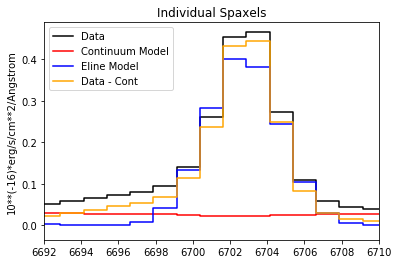

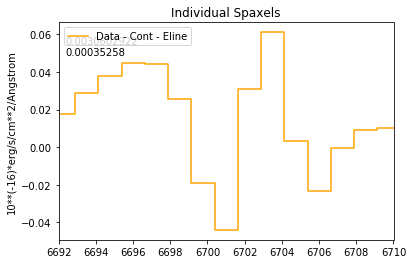

In [176]:
print(np.shape(cont_model[0].data))

#wave_range = [4950,4975] #hbeta
wave_range = [6692, 6710]

plt.clf()
plt.step(wav, hdulist[0].data[:,150,150], color='black', label = 'Data')
plt.step(wav, cont_model[0].data[:,150,150], color='red', label = 'Continuum Model')
plt.step(wav, eline_model[0].data[:,150,150], color='blue', label = 'Eline Model')

plt.step(wav, hdulist[0].data[:,150,150] -cont_model[0].data[:,150,150], color='orange', label = 'Data - Cont')
#plt.plot(wav, hdulist[0].data[:,140,150])
plt.title('Individual Spaxels')
plt.ylabel(str(hdulist[0].header['BUNIT']))
plt.xlim(wave_range)
#plt.xlim([6000,7000])
plt.legend()
plt.show()


plt.clf()

plt.step(wav, hdulist[0].data[:,150,150] -cont_model[0].data[:,150,150] -eline_model[0].data[:,150,150], 
         color='orange', label = 'Data - Cont - Eline')
plt.annotate(str(np.std(hdulist[0].data[:,150,150] -cont_model[0].data[:,150,150] -eline_model[0].data[:,150,150])),
             xy = (0.02,0.9), xycoords='axes fraction')
plt.annotate(str(np.mean(hdulist[0].data[:,150,150] -cont_model[0].data[:,150,150] -eline_model[0].data[:,150,150])),
             xy = (0.02,0.85), xycoords='axes fraction')
#plt.plot(wav, hdulist[0].data[:,140,150])
plt.title('Individual Spaxels')
plt.ylabel(str(hdulist[0].header['BUNIT']))
plt.xlim(wave_range)
#plt.xlim([6000,7000])
plt.legend()
plt.show()

Filename: /Users/beckynevin/CfA_Code/CARS_data/MUSE/HE0045-2145/fitting/full/HE0045-2145.cont_model.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  DATA          1 PrimaryHDU      44   (319, 314, 3682)   float32   
  1  BADPIX        1 ImageHDU         9   (319, 314, 3682)   uint8   
  2  NORMALIZE     1 ImageHDU         9   (319, 314, 3682)   float64   
None
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                    8 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                  319                                                  NAXIS2  =                  314                                                  NAXIS3  =                 3682                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups     

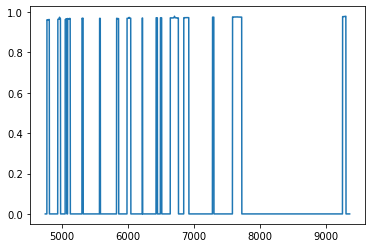

In [89]:
print(cont_model.info())
print(cont_model[1].header)
plt.plot(wav,cont_model[1].data[:,150,150]*(1-cont_model[0].data[:,150,150]))
plt.show()

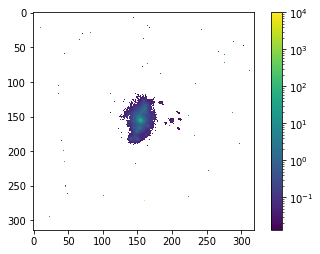

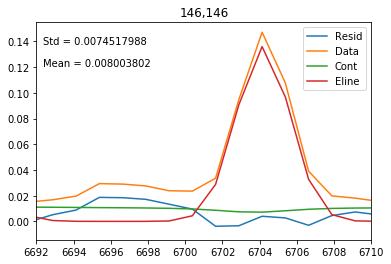

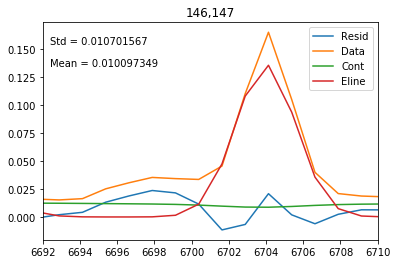

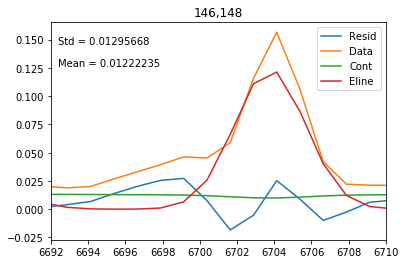

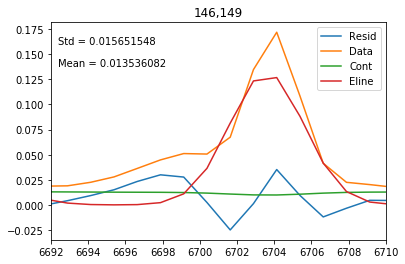

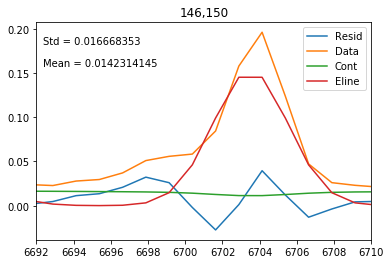

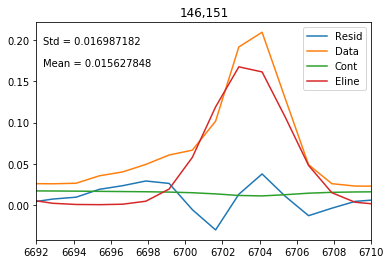

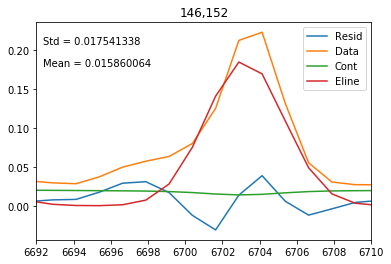

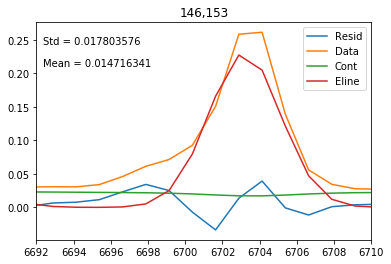

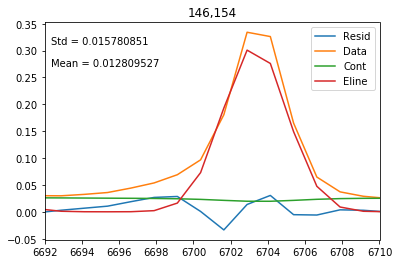

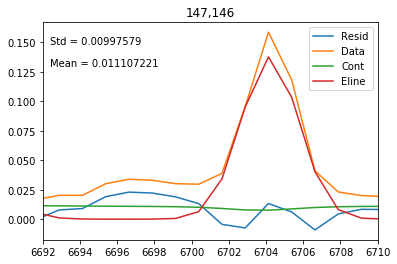

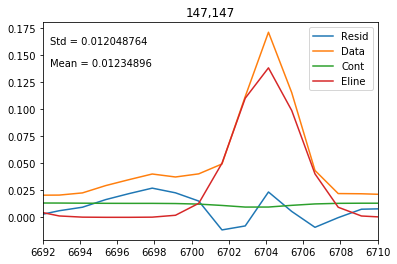

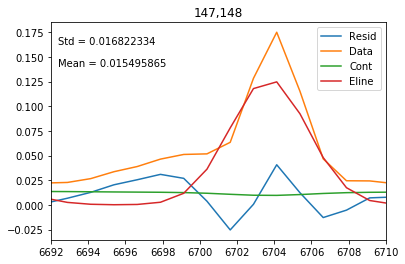

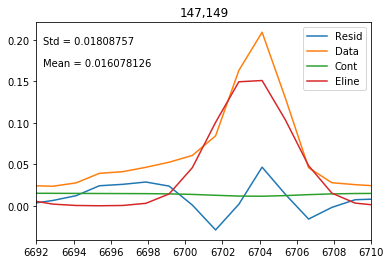

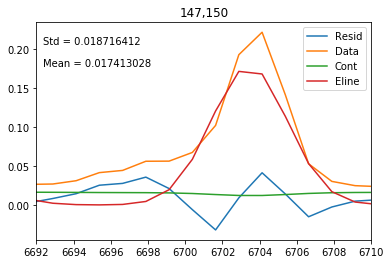

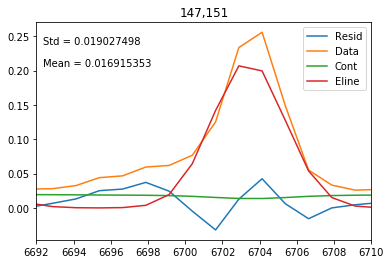

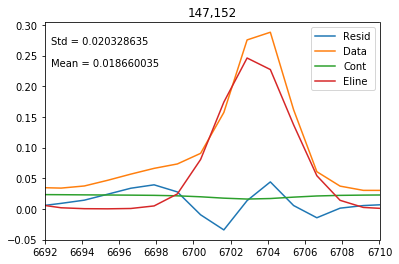

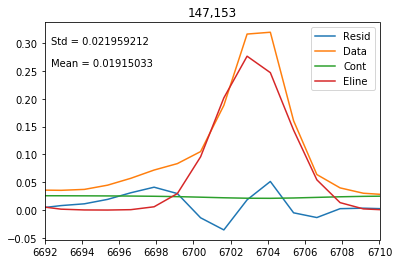

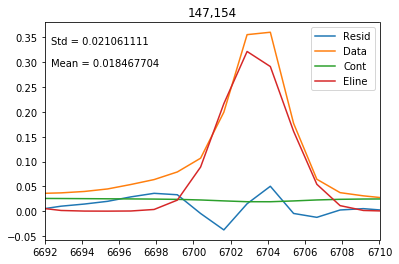

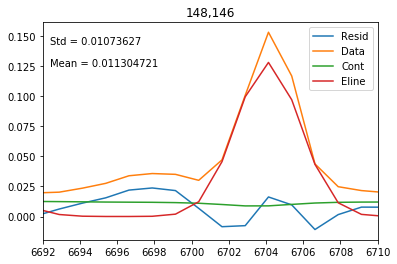

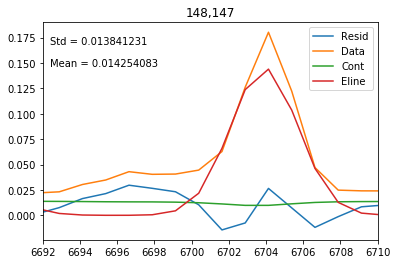

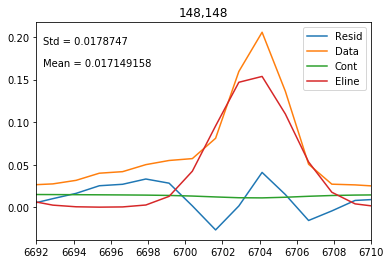

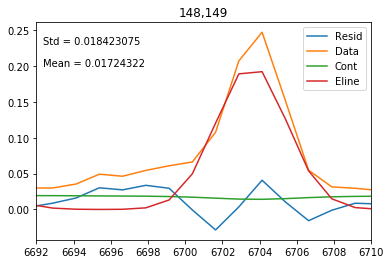

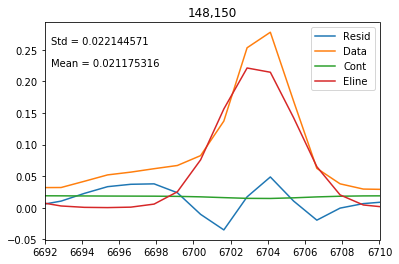

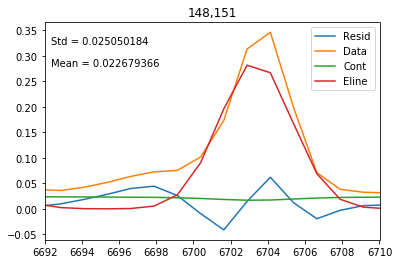

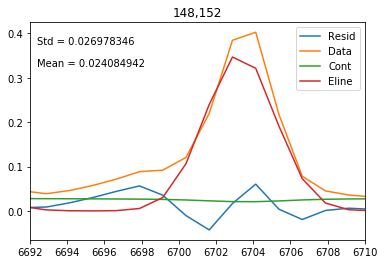

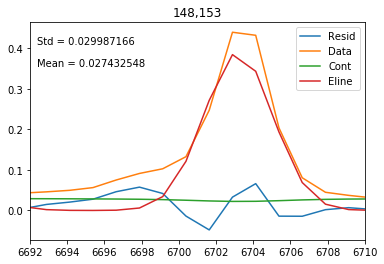

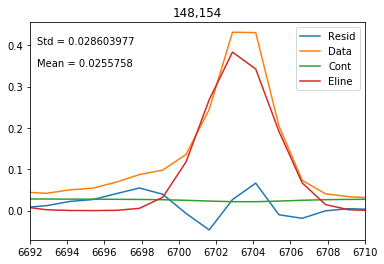

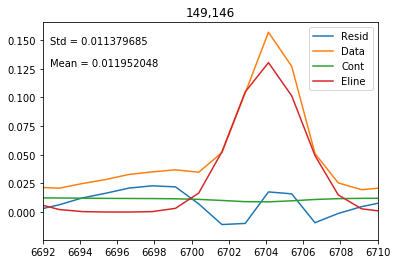

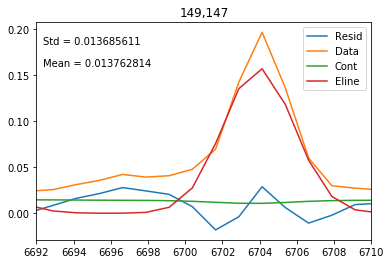

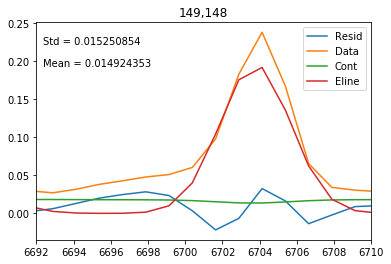

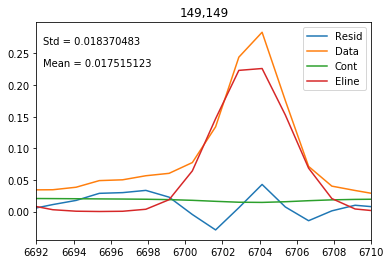

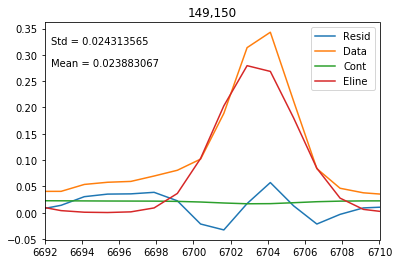

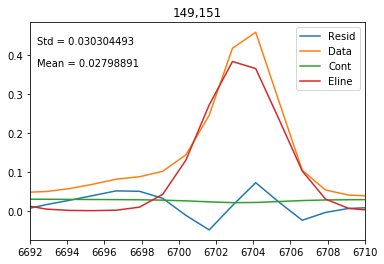

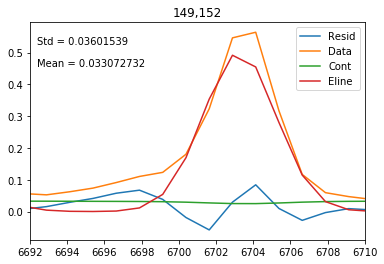

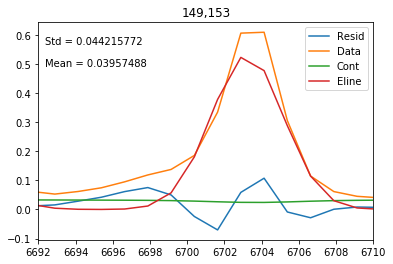

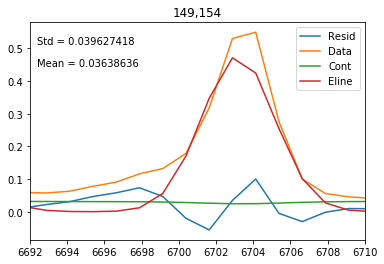

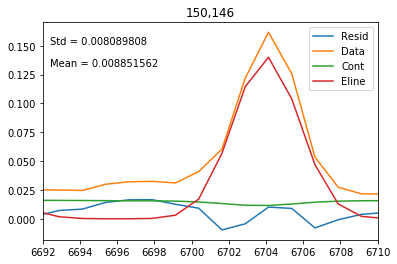

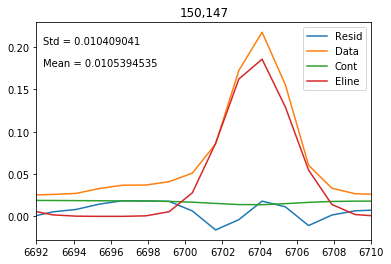

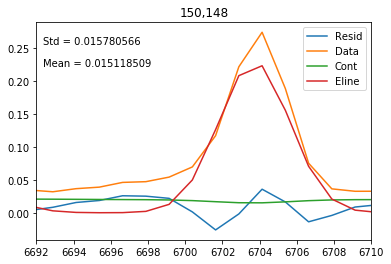

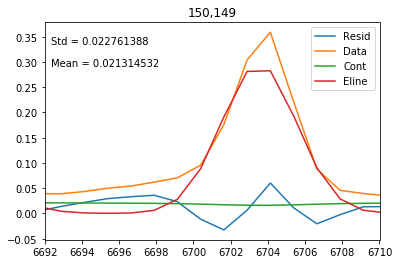

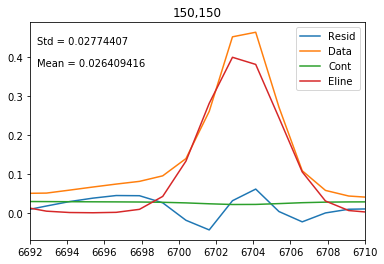

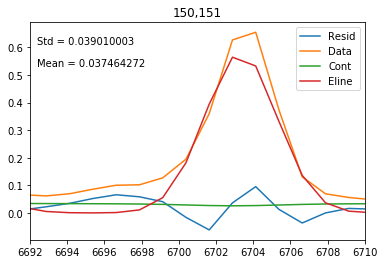

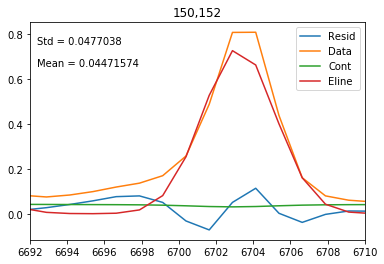

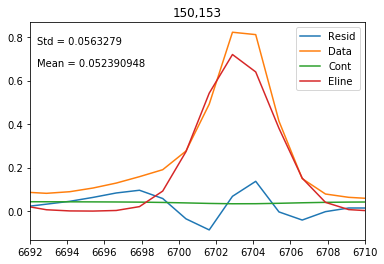

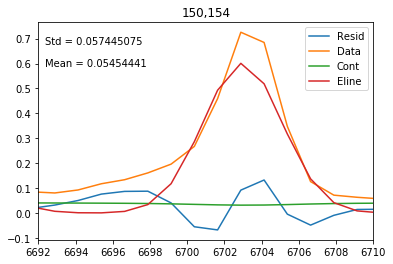

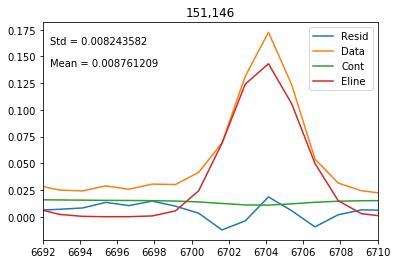

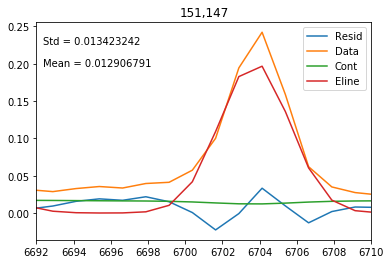

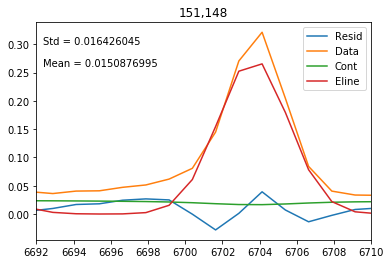

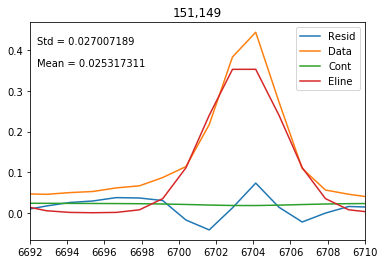

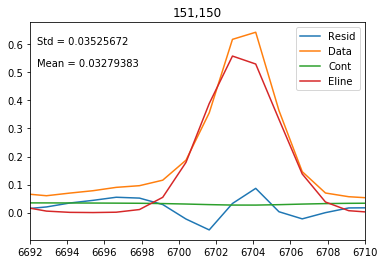

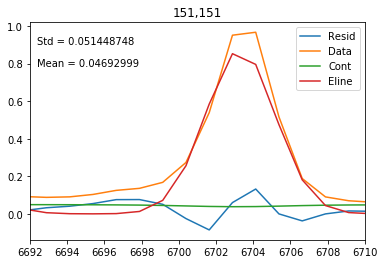

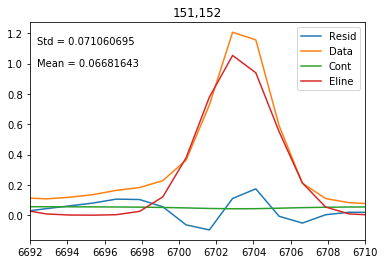

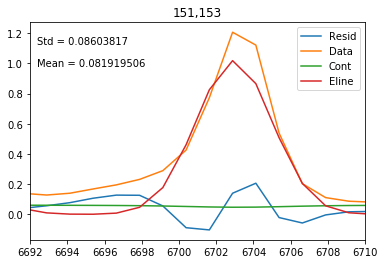

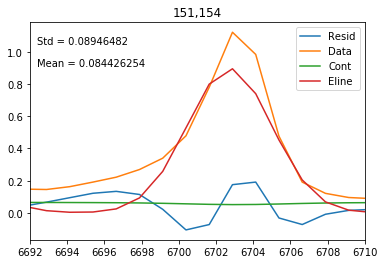

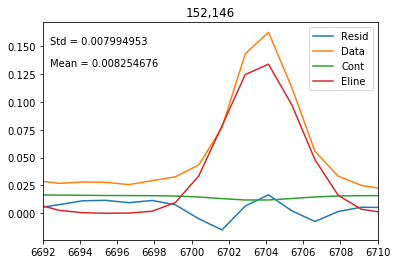

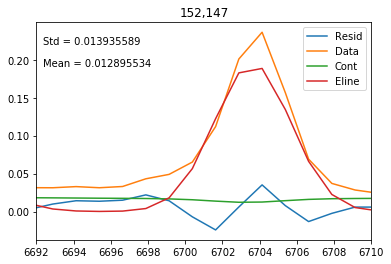

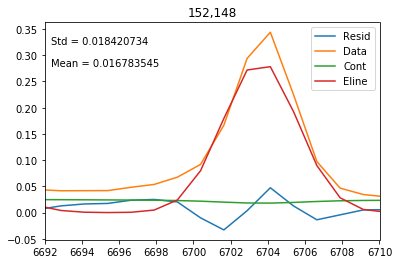

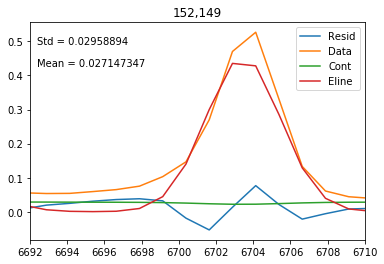

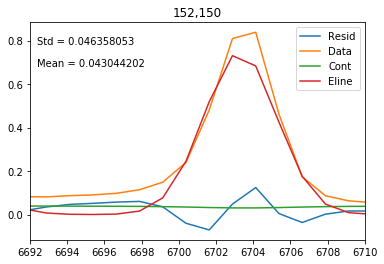

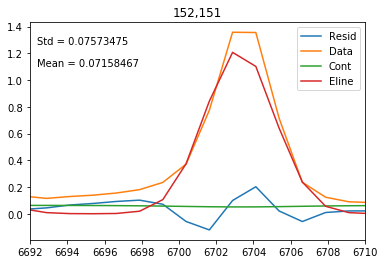

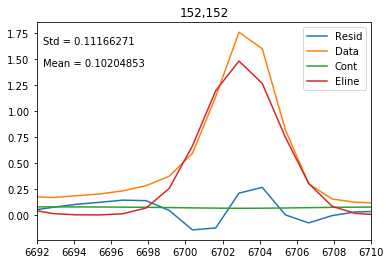

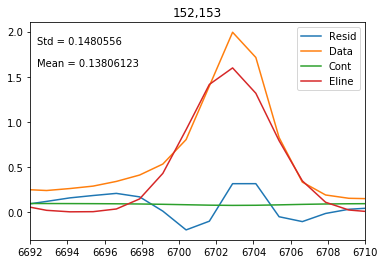

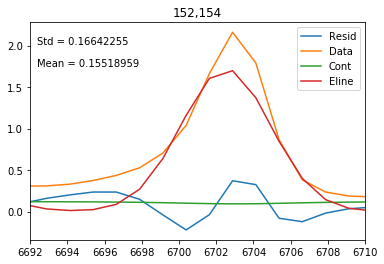

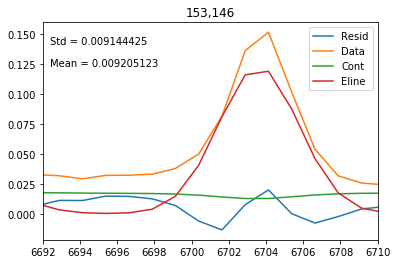

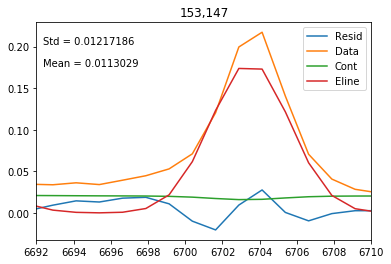

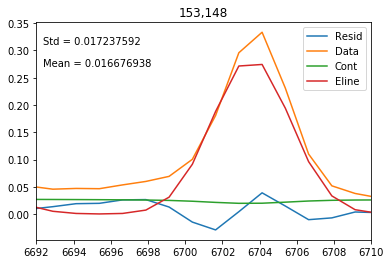

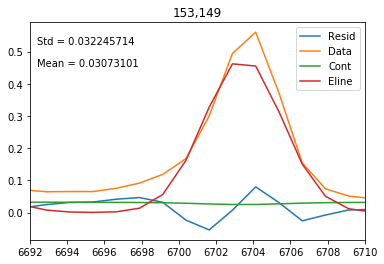

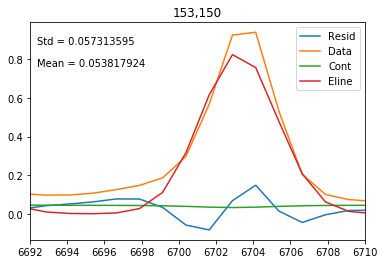

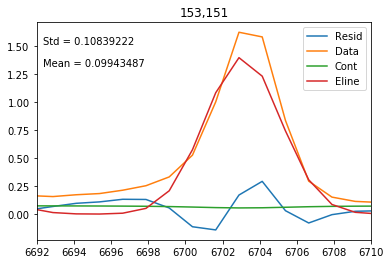

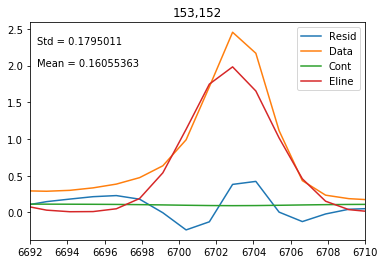

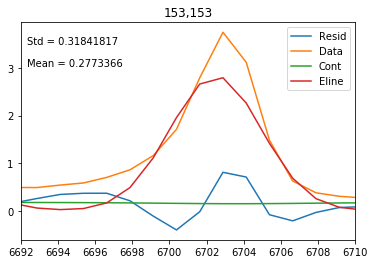

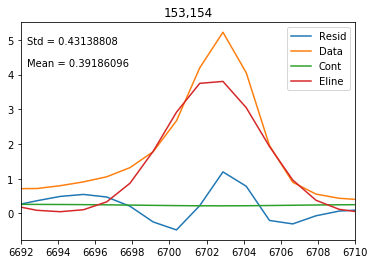

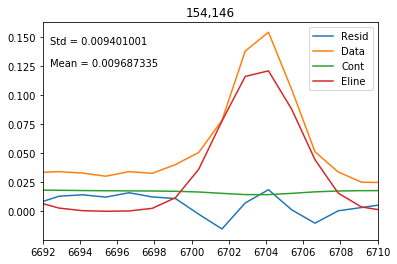

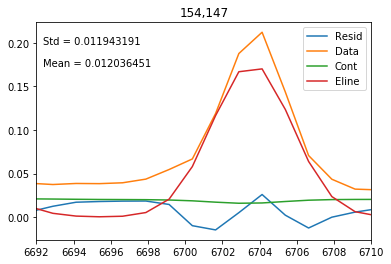

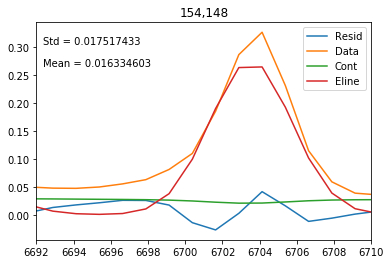

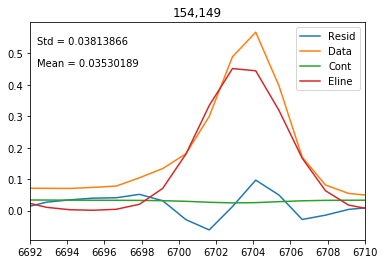

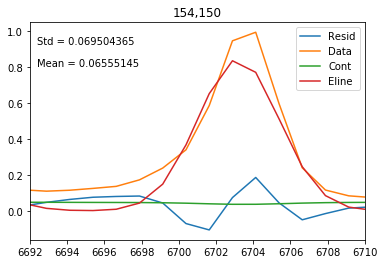

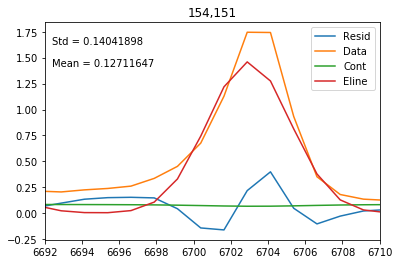

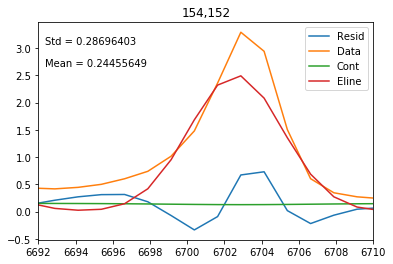

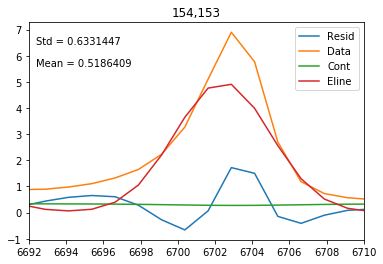

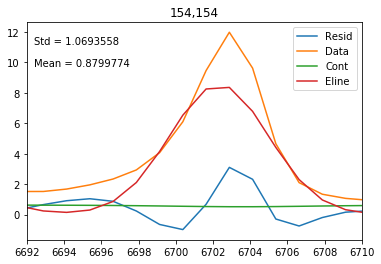

In [177]:
resid_std = np.zeros((np.shape(hdulist[0].data)[1], np.shape(hdulist[0].data)[2]))
resid_mean = np.zeros((np.shape(hdulist[0].data)[1], np.shape(hdulist[0].data)[2]))
resid_gaussian = np.zeros((np.shape(hdulist[0].data)[1], np.shape(hdulist[0].data)[2]))
wave_range = [6692, 6710]#[4950,4975]
index_1 = find_nearest(wav,wave_range[0])[0]
index_2 = find_nearest(wav,wave_range[1])[0]
#return idx, array[idx]

gas_select = (Ha_flux / Ha_flux_err > 10)
Ha_flux_map = np.full((dim[0],dim[1]) ,np.nan)
Ha_flux_map[eline_y_cor[gas_select],eline_x_cor[gas_select]] = Ha_flux[gas_select]

plt.clf()
plt.imshow(Ha_flux_map, norm = matplotlib.colors.LogNorm())

plt.colorbar()
plt.show()




for i in range(np.shape(hdulist[0].data)[1]):
    for j in range(np.shape(hdulist[0].data)[2]):
        if np.isnan(Ha_flux_map[i,j]):# or abs(150 - i) > 2 or abs(150 - j) > 2:
            continue
        residual = hdulist[0].data[:,i,j] -cont_model[0].data[:,i,j] -eline_model[0].data[:,i,j]
        OG = hdulist[0].data[:,i,j]
        
        cont = cont_model[0].data[:,i,j]
        eline = eline_model[0].data[:,i,j]
        
        if abs(150 - i) < 5 and abs(150 - j) < 5:
        #Ha_flux_map[i,j] > 10**2:
            min_here = min(OG[index_1:index_2])
            max_here = max(OG[index_1:index_2])
            plt.clf()
            plt.plot(wav, residual, label='Resid')
            plt.plot(wav, OG, label='Data')
            plt.plot(wav, cont, label='Cont')
            plt.plot(wav, eline, label='Eline')

            plt.legend()
            plt.annotate('Std = '+str(np.std(residual[index_1:index_2])), 
                         xy=(0.02,0.9), xycoords='axes fraction')

            plt.annotate('Mean = '+str(np.mean(abs(residual[index_1:index_2]))), 
                         xy=(0.02,0.8), xycoords='axes fraction')
            plt.title(str(i)+','+str(j))
            plt.xlim(wave_range)
            #plt.ylim([min_here, max_here])
            plt.show()

        '''plt.clf()
        plt.plot(wav[wave_range[0]:wave_range[1]], residual[wave_range[0]:wave_range[1]])
        plt.show()'''
        resid_std[i,j] = np.std(residual[index_1:index_2])
        resid_mean[i,j] = np.mean(abs(residual[index_1:index_2]))
        
        
        # Maybe also fit a Gaussian tot he residuals?
        # Naw it looks too difficult :()
        
        
        

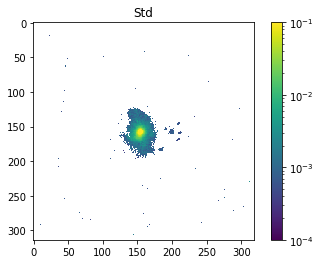

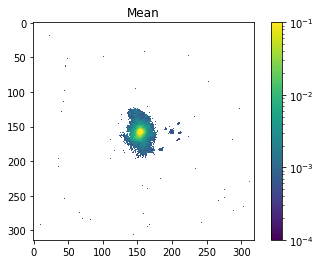

In [204]:
# This is for Hbeta

plt.clf()
plt.imshow(np.flipud(resid_std),  norm = matplotlib.colors.LogNorm(), vmin = 10**-4, vmax=10**(-1))
plt.colorbar()
plt.title('Std')
plt.show()

plt.clf()
plt.imshow(np.flipud(resid_mean), norm = matplotlib.colors.LogNorm(), vmin = 10**-4, vmax=10**(-1))
plt.colorbar()
plt.title('Mean')
plt.show()